<br></br>
# Data Mining and Decision Systems ACW
<br></br>
#### Student number: 201601628
<br>
<hr>

# 0. Notebook Initialisation

## 0.1. Package Imports
Import all libraries/packages used in the notebook.

In [1]:
import matplotlib.pyplot as plt # Visualisation library.
import seaborn as sns # Visualisation library based on matplotlib.
import sklearn as skl # Data science and machine learning library.
import pandas as pd # For reading spreadsheets.
import numpy as np # Complex array library.

## Specific sklearn imports for classifiers and stratification etc.
from sklearn import model_selection, linear_model, svm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.neighbors import KNeighborsClassifier ## https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score ## https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
from sklearn.linear_model import LogisticRegression

from collections import defaultdict # For dictionaries with uninitialised lists for values.

# Output plots within the notebook.
%matplotlib inline

# Don't output warnings (added after finishing notebook).
import warnings
warnings.filterwarnings("ignore")

## 0.2. Data Loading
Read in the file containing the data.

In [2]:
path = "data.csv" ## Relative path to train/test data.
rawData = pd.read_csv(path) ## Original data to make copies from and compare with.
rawData.head(3) ## Show dataframe to check it was read correctly.

,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
0,0.602437,218242,A-F,no,no,yes,no,no,78.0,20,NoRisk
1,0.602437,159284,TIA,no,no,no,no,no,70.0,60,NoRisk
2,0.602437,106066,A-F,no,yes,yes,no,no,95.0,40,Risk


At first glance it can be seen that all column headers are unique, so for the sake of simplicity and to avoid trivial errors, convert them to lowercase.

**NB:** all other modifications will be made to copies of this dataframe.

In [3]:
rawData.columns = [col.lower() for col in rawData.columns] ## Make headers lowercase to avoid some trivial errors.
rawData.head(0) ## Output and confirm changes.

,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label


## 0.3. Utilities
Define any utility functions or properties used throughout the notebook. Many of these were created to simplify the notebook *after* completing the work.

In [4]:
rawNRows = rawData.shape[0] ## Get number of rows in original dataframe.
rawNCols = rawData.shape[1] ## Get number of columns in original dataframe.
rawColNames = rawData.columns.values # Get column names which will often be used as an iterator.

In [5]:
## For pretty printing.
##------------------------------
# ''' n == number of indents '''
##------------------------------
def Indent(n=1):
    
    indentSize = 4
    indent = (" " * indentSize) * n
    return indent

In [6]:
## Iterate over dictionary items and output the key and any values.
##------------------------------
# ''' collection == dictionary object '''
# ''' label == string to prefix each dictionary key e.g. "1. " '''
##------------------------------
def PrintDict(collection, label = ""):
    i = 1
    for key, value in collection.items():
        print("\n________________________________________________________________\n")  
        print(label + str(i) + ": " + key)
        i += 1

        for val in value:
            print(val)
    
    print("\n________________________________________________________________\n")  

In [7]:
## Impute a value in a given record based on the mode in a collection, using the knowledge that
## the data set is quite homogenous.
##------------------------------
# ''' toImpute == feature to impute '''
# ''' record == pd series object '''
# ''' df == pd dataframe object '''
# ''' ignore == list of columns to ignore '''
# ''' output == bool : True = print result '''
##------------------------------
def NNImpute(toImpute, record, df, ignore=[], output=True, method="mode"):
    neighbours = []
    
    # Look for records that are duplicated when ignoring the specifed columns and target feature.
    ignore.append(toImpute)
    tempDf = df.drop(columns=ignore)
    tempSeries = record.drop(labels=ignore)

    for index, row in tempDf.iterrows():
        if row.all() == tempSeries.all():
            neighbours.append(index)

    if method == "mode":
        # Get the mode class of the neighbours.
        avg = df.iloc[neighbours][toImpute].mode()[0]
    elif method == "mean":
        # Get the mean of the neighbours.
        avg = df.iloc[neighbours][toImpute].mean()

    if output:
        print("Based on the " + method + " of " + str(len(neighbours)) + " neighbours: " + str(avg))

    return avg

In [8]:
## Check for duplicates.
##------------------------------
## ''' df == dataframe to check for duplicates '''
## ''' ignore == list of columns to drop '''
## ''' keep == "first"/"last"/False which duplicate to keep '''
##------------------------------
def CheckForDuplicates(df, ignore=[], keep="first"):
    dupes = df.drop(columns=ignore)[df.drop(columns=ignore).duplicated(keep=keep) == True]
    if len(dupes) > 0:
        return dupes, dupes.index.values
    else:
        return pd.DataFrame(), [] # "No duplicates."

In [9]:
## Check for nans/missing data.
##------------------------------
## ''' df == pd dataframe object to check '''
## ''' colsToCheck == list of column headers '''
##------------------------------
def FindMissing(df, colsToCheck):
    # Convert empty strings and variations of nan to np.nan.
    df = df.replace(r'^\s*$', np.nan, regex=True)
    df = df.replace(r'(?i)nan', np.nan, regex=True)
    
    indexes =[]
    for col in colsToCheck:
        nans = df[col][df[col].isna() == True] ## Get all nan values in the series (df[col]).
        if len(nans) > 0:
            indexes += list(nans.index.values) ## Get the indexes of those nans.

    nans = df.iloc[indexes]
    print(str(len(nans)) + " records with missing values:")
    
    return nans

In [10]:
## Plot feature distribution and distribution of 'label' within that feature..
##------------------------------
## ''' df == pd dataframe object '''
## ''' col == string: feature to check '''
## ''' xCol == string: column to spread the data accross the x axis '''
## ''' categoric == Bool: output statistics  '''
##------------------------------
def PlotDist(df,col,xCol="id",categoric=True):
    df = df.copy()

    ## Create histogram on left to show distribution of values for this feature 'col'.
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1, title=col.upper() + " Value Distributon")
    df[col].hist()

    ## Create a scatter plot on right with hue as label to see multivariate distributon.
    plt.subplot(1, 2, 2, title="Classification Distributon for " + col.upper())
    sns.scatterplot(x=xCol, y=col, hue="label", data=df) ## hue == label so that class distribution within a feature is visible.

    plt.show()
    
    if (categoric):
        ## Print data description statistics.
        print("Classification distribution metrics:")
        categories = df[col].unique() 
        for category in categories:
            cat = df[df[col] == category]
            description = cat["label"].describe()
            try:
                percent =  round((100/description["count"]) * description["freq"],2)
                if (np.isnan(percent)):
                    print("Skipped nans...")
                    continue

                print("Category: " + str(category))
                print(description)
                print("% of most frequent (" + (description["top"]) + "): " + str(percent) + "\n")
            except:
                pass ## Div by 0 (nan)

In [11]:
## Wrapper for training n models on k datasets and then returning TEST metrics.
##------------------------------
## ''' models == dict of models '''
## ''' dfs == dict of pd dataframes '''
## ''' kfolds == int: n folds for cross validation  '''
##------------------------------
def TrainPred(models, dfs, kfolds=5):
    results = [] ## Build list of results to output as dataframe.
    
    # Train and test each model against each dataset.
    for modelName, model in models:
        for dfName, df in dfs:
            
            # Separate data into labels and features.
            data = df.drop(columns="label")
            labels = df["label"]

            ## Get kfold scores to validate model performance over whole dataset.
            scores = cross_val_score(model, data, labels, cv=kfolds,)

            ## Get avg kfold score for printing to results table.
            avg = 0
            for score in scores:
                avg += score
            avg /= kfolds

            ## Create 70:30 tts for getting test metrics.
            xtr, xte, ytr, yte = skl.model_selection.train_test_split(data, labels, shuffle=True, random_state=69, test_size=0.3)
            model.fit(xtr,ytr) # Train the model.
            pred = model.predict(xte) # Make predictions on test set.

            tn, fp, fn, tp = confusion_matrix(yte, pred).ravel() # Create confusion matrix
            sens = tp / (tp + fn) # Calculate sensitivity (true neg rate)
            spec = tn / (tn + fp) # Calculate specificty (true pos rate)
            prec = tp / (tp + fp) # Calculate precision.
            f1 = f1_score(yte, pred)
            acc = accuracy_score(yte, pred)

            # Build results table.
            results.append({
                            'Model': modelName,
                            'Data': dfName,
                            'KFold Avg': avg,
                            'TP': tp,
                            'FP': fp,
                            'TN': tn,
                            'FN': fn,
                            'Acc': acc,
                            'Spec (tpR)': spec,
                            'Sens (tnR)': sens,
                            'Prec': prec,
                            'F1 Score': f1
                           })
    
    # Return the dataframe sorted by descending f1 scores.
    return pd.DataFrame(results).sort_values("F1 Score", ascending=False)

<hr>

# CRISP DM
Herein, the CRISP DM data methodology is followed (as close as is possible in the context of this project).

<img src="crisp-dm.png" style="max-height:300px">

Most time is spent in the 'Data Understanding' phase to make up for the fact that there is no client communcation beyond the given information and to allow for better informed decisions in the 'Data Preperation' and 'Modelling' stages.

# 1. Business Understanding
Beyond the given task definition and data dictionary, there will be no additional client/business communication. Therefore, some assumptions must be made based on personal experience, domain knowledge, and research.

 <hr>

**Below is a brief breakdown** of the problem definition and some domain considerations:

DOMAIN: Cardio-vascular medicine / healthcare

- As a healthcare dataset it may be "natural", anonymised patient data, study data (e.g. clinical trial), or an aggregation of many different datasets.
- There is a chance there is "control" data (healthy cohorts) within the dataset or, similarly, focus groups that consist of unhealthy cohorts.
- Due to the (often) subjective nature of clinical diagnosis (i.e. different doctors with varying levels of experience make the diagnoses), some data may be mislabelled.
- Some diagnoses or features may be self-certified or be derived from incorrect patient interpretations (e.g. "Yes, I have been feeling...").
- Some features might represent the same thing (e.g. an alternative clincal test - both may be conducted or one might replace the other). 

PROBLEM TYPE: Classification

INPUTS: Tabulated patient data; (up-to) 1520 records of 11 features

OUTPUTS:
- Risk
- No Risk

In terms of performance metrics, **sensitivity and specificity** will be particularly important for acceptance of the model. Since the classifier is predicting risk of mortality, false negatives  need to be minimised to reduced missed cases and, ultimately, unecessary deaths. Perhaps to a lesser extent, false positives are also important in order to limit uncessary treatment and so on. Specificty and Sensitivity can produce a weighted "accuracy" called the **f1 score**, which provides a better representation of model performance on imbalanced data (e.g. if there are more no-risk cases).

<hr>

**More objectively**, domain-specific terminology from the provided data dictionary can be researched further:

- Atrial Fibrillation
    - A form of **arrythmia** (https://www.nhs.uk/conditions/arrhythmia/).
    - Increases risk of stroke (https://www.nhs.uk/conditions/arrhythmia/)
    
    
- Asymptomatic Stenosis
    - Narrowing of the cartoid artery without recent history of TIA  or ischemic stroke (https://www.uptodate.com/contents/management-of-asymptomatic-carotid-atherosclerotic-disease).


- Cardiovascular Arrest
    - When the heart stops pumping blood - NOT a heart attack (https://www.bhf.org.uk/informationsupport/conditions/cardiac-arrest).
    - Can be caused by arrhythmias (https://www.heart.org/en/health-topics/cardiac-arrest/about-cardiac-arrest).
    
    
- Transient Ischemic Attack (mini heart attack)
    - Risk increased by a-f, asx, diabetes and hypertension (https://www.nhs.uk/conditions/transient-ischaemic-attack-tia/; https://www.cardiosmart.org/Healthwise/hw22/6606/hw226606).
    - Actually a **mini-stroke**, not heart attack.


- Diabetes
    - Type 2 makes up 90% of cases, but could be type 1 or a mix of both (https://www.bhf.org.uk/informationsupport/risk-factors/diabetes).


- IHD/CAD (Ischemic Heart Disease/Coronary Artery Disease)
    - Narrowing or blockage of the coronary arteries (https://www.cancer.gov/publications/dictionaries/cancer-terms/def/coronary-heart-disease).


- Hypertension
    - i.e high blood pressure.


- Arrhythmia (erratic heart beat)
    - Main types include **a-f**, tachcardia, bradycardia heart block and ventricular fibrilation (may cause cardiac arrest) (https://www.nhs.uk/conditions/arrhythmia/).


- IPSI (ipsilateral cerebral ischemic lesions)
    - Ipsilateral means "same side". Based on the context, the side of comparsion is likely the side of the brain that the stroke occurred.


- Contra (contralateral cerebral ischemic lesions)
    - Contralateral means "opposite side". Based on the context, the side of comparsion is likely the side of the brain that the stroke occurred.


- (History) Cardiovascular Interventions
    - Typically, cardiac invasive treatments e.g. catheterisation. (https://onlinelibrary.wiley.com/doi/book/10.1002/9781444316704)

<hr>

<b style="color:red;">Based on these findings, there are some assumptions to be made:</b>

- Patients with an indication of "a-f" should also be be recorded as having an arrhythmia.


- The indication feature almost appears ordinal, with a-f and asx being cause for cva and tia; although it is difficult to verify this without communicating with professionals.


- Assuming IPSI and Contra are recorded at the same time in relation to the same stroke or event (and since IPSI is referring to the percentage of lesions on the same side and Contra on the opposite side) it would make sense for the 2 values to have sum of 100%

<hr>
   

# 2. Data Understanding
This section focuses on an in-depth understanding of the given data, its correctness and any patterns.
<hr>

# 2.1. Data Dictionary
The data dictionary with all expected features and their format is included in the table below.

<table>
    <tbody>
        <tr>
            <td>
                <p><strong>Attribute</strong></p>
            </td>
            <td>
                <p><strong>Value Type</strong></p>
            </td>
            <td>
                <p><strong>NumberOfValues</strong></p>
            </td>
            <td>
                <p><strong>Values</strong></p>
            </td>
            <td>
                <p><strong>Comment</strong></p>
            </td>
            <td>
                <p><strong>Non-clinical Description</strong></p>
            </td>
        </tr>
        <tr>
            <td>
                <p>Random</p>
            </td>
            <td>
                <p>Real</p>
            </td>
            <td>
                <p>Number of Records</p>
            </td>
            <td>
                <p>Unique</p>
            </td>
            <td>
                <p>Real number of help in randomly sorting the data records</p>
            </td>
            <td>
                <p>Real number of&nbsp;help&nbsp;in randomly sorting the data records: Should be unique values.</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>Id</p>
            </td>
            <td>
                <p>Integer</p>
            </td>
            <td>
                <p>Max of Number of Records</p>
            </td>
            <td>
                <p>Unique to patient</p>
            </td>
            <td>
                <p>Anonymous patient record identifier: Should be unique values unless patient has multiple sessions</p>
            </td>
            <td>
                <p>Anonymous patient record identifier: Should be unique value per patient. Patient can have multiple sessions</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>Indication</p>
            </td>
            <td>
                <p>Nominal</p>
            </td>
            <td>
                <p>Four</p>
            </td>
            <td>
                <p>{a-f, asx, cva, tia}</p>
            </td>
            <td>
                <p>What type of Cardiovascular event triggered the hospitalisation?</p>
            </td>
            <td>
                <p>What type of Cardiovascular event triggered the hospitalisation?</p><p> a-f :&nbsp;Atrial-Fibrillation</p>
                <p>asx&nbsp;:&nbsp;Asymptomatic Stenosis&nbsp;</p><p>cva&nbsp;: Cardiovascular Arrest</p>
                <p>tia&nbsp;:&nbsp;Transient Ischemic Attack ("mini-heart attack")</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>Diabetes</p>
            </td>
            <td>
                <p>Nominal</p>
            </td>
            <td>
                <p>Two</p>
            </td>
            <td>
                <p>{no, yes}</p>
            </td>
            <td>
                <p>Does the patient suffer from Diabetes?</p>
            </td>
            <td>
                <p>Does the patient suffer from Diabetes?</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>IHD</p>
            </td>
            <td>
                <p>Nominal</p>
            </td>
            <td>
                <p>Two</p>
            </td>
            <td>
                <p>{no, yes}</p>
            </td>
            <td>
                <p>Does the patient suffer from Coronary artery disease (CAD), also known as ischemic heart disease (IHD)?</p>
            </td>
            <td>
                <p>Does the patient suffer from Coronary artery disease (CAD), also known as ischemic heart disease (IHD)?</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>Hypertension</p>
            </td>
            <td>
                <p>Nominal</p>
            </td>
            <td>
                <p>Two</p>
            </td>
            <td>
                <p>{no, yes}</p>
            </td>
            <td>
                <p>Does the patient suffer from Hypertension?</p>
            </td>
            <td>
                <p>Does the patient suffer from Hypertension?</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>Arrhythmia</p>
            </td>
            <td>
                <p>Nominal</p>
            </td>
            <td>
                <p>Two</p>
            </td>
            <td>
                <p>{no, yes}</p>
            </td>
            <td>
                <p>Does the patient suffer from</p>
                <p>Arrhythmia (i.e. erratic heart beat)?</p>
            </td>
            <td>
                <p>Does the patient suffer from Arrhythmia (i.e. erratic&nbsp;heart beat)?</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>History</p>
            </td>
            <td>
                <p>Nominal</p>
            </td>
            <td>
                <p>Two</p>
            </td>
            <td>
                <p>{no, yes}</p>
            </td>
            <td>
                <p>Has the patient a history of</p>
                <p>Cardiovascular interventions?</p>
            </td>
            <td>
                <p>Has the patient a history of Cardiovascular interventions?</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>IPSI</p>
            </td>
            <td>
                <p>Integer</p>
            </td>
            <td>
                <p>Potentially 101</p>
            </td>
            <td>
                <p>[0, 100]</p>
            </td>
            <td>
                <p>Percentage figure for cerebral ischemic lesions defined as ipsilateral</p>
            </td>
            <td>
                <p>Percentage figure for cerebral ischemic lesions defined as ipsilateral</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>Contra</p>
            </td>
            <td>
                <p>Integer</p>
            </td>
            <td>
                <p>Potentially 101</p>
            </td>
            <td>
                <p>[0, 100]</p>
            </td>
            <td>
                <p>Percentage figure for contralateral cerebral ischemic lesions</p>
            </td>
            <td>
                <p>Percentage figure for contralateral cerebral ischemic lesions</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>Label</p>
            </td>
            <td>
                <p>Nominal</p>
            </td>
            <td>
                <p>Two</p>
            </td>
            <td>
                <p>{risk, norisk}</p>
            </td>
            <td>
                <p>Is the patient at risk (Mortality)?</p>
            </td>
            <td>
                <p>Is the patient at risk (Mortality)?</p>
            </td>
        </tr>
    </tbody>

<br>
<b style="color: red;">NOTE:</b> "Session" is also included in the non-clinical description, but not included in the data dictionary.
<br>
<table>
    <tr>
        <td>
            <p><strong>Attribute</strong></p>
        </td>
        <td>
            <p><strong>Value Type</strong></p>
        </td>
        <td>
            <p><strong>NumberOfValues</strong></p>
        </td>
        <td>
            <p><strong>Values</strong></p>
        </td>
        <td>
            <p><strong>Comment</strong></p>
        </td>
        <td>
            <p><strong>Non-clinical Description</strong></p>
        </td>
    </tr>
    <tr>
        <td>
            <p>Session</p>
        </td>
        <td>
            <p>Unknown</p>
        </td>
        <td>
            <p>Max Number of Records (assumed)</p>
        </td>
        <td>
            <p>Unique to patient</p>
        </td>
        <td>
            <p>Unknown</p>
        </td>
        <td>
            <p>Anonymous patient session identifier.</p>
        </td>
    </tr>
</table>
<br>



**Looking at the data dictionary** it can be seen that the "Random" and "Id" attributes are supposed to be unique. If this is true, the features should have very little correlation with other features and provide no benefit to any models. Therefore, hopefully they can be discarded to reduce the dimensionality of the problem.

The **Label** feature is the feature we want to predict and our ground-truth.

<hr>

# 2.2. Data Correctness
Check for data conformity to data dictionary and explore common pitfalls (e.g. missing or duplicate data).

<hr>

## 2.2.1. Conformity to Data Dictionary
The data dictionary serves as the foundation for assumptions made regarding the data.

The following python-object is a distillation of the data-dictionary which can be used to check the expected values/types etc. against the *actual* data.

In [12]:
## Object description:
# key == column/feature name.
# nVals == range of expected values for a continuous column.
# vals == possible values for any categoric or discrete column.

assumptions = {
    "random":{ ## Col name.
        "nVals": (rawNRows, rawNRows), # Range: unique per record. ## Real.
    },  
    "id":{
        "nVals": (1, rawNRows), ## Range: unique per patient. ## Integer.
    },
    "indication":{
        "vals": ["a-f","asx","cva","tia"] ## Possible values (except nan).
    },
    "diabetes":{ "vals": ["yes", "no"] },
    "ihd":{ "vals": ["yes", "no"] },
    "hypertension":{ "vals": ["yes", "no"] },
    "arrhythmia":{ "vals": ["yes", "no"] },
    "history": { "vals": ["yes", "no"] },
    "ipsi": {
        "vals": np.arange(0,101) # Percentage 0-100.
    },
    "contra": { "vals": np.arange(0,101) },
    "label": { "vals": ["risk", "norisk"] },
    
    "session":{ ## This feature was given separate to the dictionary.
        "nVals": (1, rawNRows), ## Unique per patient (assumed).
    },
}

<hr>

#### Compare Actual Data with Assumptions Object

In [13]:
df = rawData.copy() # Temporary copy of the unmodified, raw data.
discrepancies = defaultdict(list) # Collate discrepencies.

# Iterate over assumptions object.
for key, value in assumptions.items():
    
    # If the expected feature exists in the actual data.
    if key in rawColNames:
        actualValues = df[key].dropna().unique() ## Ignore nan values in uniques (handle seperately).
    
        try:
            # Check expected values.
            expectedValues = value["vals"]
            if (not(set(actualValues) & set(expectedValues))):
                discrepancies["EXPECTED VALUES"].append(Indent(2) + key + "\n" + Indent(3)+ "Expected: " + str(set(expectedValues)) + "\n" + Indent(3)+ "Actual: " + str(set(actualValues)) + "\n")
        except:
            # No "vals" key; value is expected to be unique (nVals).
            actualNValues = len(actualValues)
            expectedNValues = value["nVals"]
            if (not(actualNValues >= expectedNValues[0]) or not(actualNValues <= expectedNValues[1])): ## Check actual number of values is within the expected range.           
                discrepancies["NUMBER OF UNIQUE VALUES"].append(Indent(2) + key + "\n" + Indent(3) + "Expected: " + str(expectedNValues) + "\n" + Indent(3)+ "Actual: " + str(actualNValues))
    else:
        # Expected column isn't present.
        discrepancies["MISSING COLUMNS"].append(key)

Format and output any descrepancies.

In [14]:
PrintDict(discrepancies, "Discrepancy ")


________________________________________________________________

Discrepancy 1: NUMBER OF UNIQUE VALUES
        random
            Expected: (1520, 1520)
            Actual: 1222

________________________________________________________________

Discrepancy 2: EXPECTED VALUES
        indication
            Expected: {'cva', 'tia', 'a-f', 'asx'}
            Actual: {'CVA', 'A-F', 'TIA', 'Asx', 'ASx'}

        contra
            Expected: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}
            Actual: {'95', '40', '90 ', '90', '60 ', '62', '85 ', '75 ', '16 ', '50', '73 ', '30', '100', '80 ', '20 ', '30 ', '50 ', '70 ', '35', '35 ', '70', '

...

**Discrepancy 1: NUMBER OF UNIQUE VALUES**
    
- RANDOM was expected to be unique per patient, but only 1222 of 1520 are unique. Presumably, this can be attributed to null or duplicate values which is checked below.

In [15]:
# Get number of random attributes that aren't unique.
nMissing = df["random"].shape[0] - df["random"].unique().shape[0]

# Get number of random attributes that are duplicated or null.
nDupes = df[df["random"].duplicated() == True].shape[0] ## Get number of duplicate random attributes.
nNan = df[df["random"] == np.isnan].shape[0]

# Calculate number of non-unique values not accounted for by nans and dupes.
stillMissing = nMissing - (nDupes + nNan)

print(str(nMissing) + " values are not unique.")
print(str(nDupes) + " 'random' values are duplicated.")
print(str(nNan) + " 'random' values are nan.")
print (str(stillMissing) + " non-unique records unaccounted for.")

298 values are not unique.
298 'random' values are duplicated.
0 'random' values are nan.
0 non-unique records unaccounted for.


The random feature isn't unique as described in the data dictionary. Records where the random attribute is duplicated should be inspected further.

In [16]:
## View all duplicate values.
randomDupes = df[df["random"].duplicated(keep=False)]
randomDupes.head() # Output first 5.

,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label
0,0.602437,218242,A-F,no,no,yes,no,no,78.0,20,NoRisk
1,0.602437,159284,TIA,no,no,no,no,no,70.0,60,NoRisk
2,0.602437,106066,A-F,no,yes,yes,no,no,95.0,40,Risk
8,0.678157,256128,TIA,no,no,yes,no,no,81.0,20,NoRisk
10,0.678157,174588,CVA,no,yes,yes,yes,no,75.0,50,Risk


Records don't appear to be duplicated where the random attribute is duplicated (i.e. other atrributes have varying values) and it is apparent that some random codes are duplicated more than once (e.g. indexes 0, 1 and 2).

Considering the absence of the session column and the fact that the Id feature is unique (therfore IS unique per patient), it could be possible that the Id feature is actually the missing session column, and the random code is the patient id.

To support or disprove this, the following looks at each random code to see if any diabetes or history values change more than once per random code - which shouldn't happen in real world data. If no such pattern is detected, this supports the idea that random is could be the patient id and the id could be the session.

In [17]:
contradictions = []

# Iterate through all the unique values in random.
for randVal in df["random"].unique():
    
    # Get the records with the current random value being inspected.
    randDf = df[df["random"] == randVal]
    
    try:
        # See if the value for history changes more than once. 
        if randDf["history"].value_counts()["yes"] > 1:
            contradictions.append(randVal)
            continue
    except:
        pass
    
    try:
        # See if the value for diabetes changes more than once. 
        if randDf["diabetes"].value_counts()["yes"] > 1:
            contradictions.append(randVal)
            continue
    except:
        pass

# Report any contradictions.
if len(contradictions) < 1:
    print("No contradictions found.")
else:
    contradictions ## Output list of random codes which disprove random being id.

No contradictions found.


**It seems plausable that the random feature could be a patient identifier and the id column could be a unique identifier for the session.**

**Arguments against this suggestion** include the fact that values range between 0-1 and aren't in a consistent format (varying decimal places), which supports the concept of a sorting utility, and that the values in the id column are *very* unconventional for denoting sessions (expected values would be simpler, e.g. bl/baseline, 1/V1/V01).

<br>

<p><b style="color: red">ACTION:</b> Maintain the <b>consideration</b> that the random feature may be a patient identifier.<p>

<hr>


**Discrepancy 2: EXPECTED VALUES**
    
- **INDICATION** had an unexpected variant of ASx/Asx. Clinical research also abbreviates the condition as "ASX" suggesting that they are the same class as stipulated by the data dictionary (https://www.sciencedirect.com/science/article/pii/S0741521415010241).
    
<p><b style="color: red">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ACTION:</b> Treat variations of "asx" as the same category.<p>

In [18]:
# These changes are fundamental, so best to work with them now.
correctedData = rawData.copy()

# Make all indication categories lowercase.
correctedData["indication"] = correctedData["indication"].apply(lambda x: str(x).lower())
correctedData["indication"].unique() # Output and confirm changes.

array(['a-f', 'tia', 'cva', 'asx', 'nan'], dtype=object)

<br>

- **CONTRA** is formatted as a string in the actual data, rather than the expected numeric format, although (with the exception of null values) the numeric equivalents are all within the expected range.

<p><b style="color: red">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ACTION:</b> Convert contra values to numeric.<p>

In [19]:
# Convert empty strings to nan.
correctedData['contra'] = correctedData['contra'].replace(r'^\s*$', np.nan, regex=True)
# Convert all values to numeric.
correctedData["contra"] = correctedData["contra"].apply(lambda x: float(x))
correctedData["contra"].head(3) # Output and confirm changes.

0    20.0
1    60.0
2    40.0
Name: contra, dtype: float64

<br>


- **LABEL** has an additional, unexpected category: "Unknown".

In [20]:
## Output all values where the value of the label feature equals "Unknown".
correctedData[correctedData["label"] == "Unknown"]

,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label
475,0.298074,173791,asx,no,yes,yes,no,no,70.0,55.0,Unknown
523,0.460170,283846,cva,no,no,yes,yes,no,95.0,100.0,Unknown


Since the requested outputs of the end-product are risk and norisk, and the fact that there are only 2 of 1520 datapoints with this classification (overwhelming imbalance); they are useless.

**The options are** to either impute the values, or drop them: although it isn't expected that either will have a *significant* effect since only 2 records are affected.

In [21]:
for index in correctedData[correctedData["label"] == "Unknown"].index.values: ## Foreach unknown classification.
    NNImpute("label", correctedData.iloc[index], correctedData, ignore=["random", "id"]) ## Calculate (not apply) imputations.

Based on the mode of 23 neighbours: NoRisk
Based on the mode of 283 neighbours: Risk


<p><b style="color: red">ACTION:</b> Create a copy of the correctedData that includes imputed labels<p>

In [22]:
labelsImputed = correctedData.copy()
labelsImputed.at[475, "label"] = "NoRisk" ## Set the "Unknown" to the imputed calssification.
labelsImputed.at[523, "label"] = "Risk" ## Set the "Unknown" to the imputed calssification.

labelsImputed.iloc[[475,523]] ## Confirm change.

,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label
475,0.298074,173791,asx,no,yes,yes,no,no,70.0,55.0,NoRisk
523,0.460170,283846,cva,no,no,yes,yes,no,95.0,100.0,Risk


<hr>


**Discrepancy 3: MISSING COLUMNS**
    
- **SESSION**, although not strictly in the data dictionary, has been referred to several times.

It's absence *shouldn't* pose a problem, since the classification task is not using time-series data or predicting progression rates, and it is natural for a person's symptoms and risk factor to change visit to visit. 

Furthermore, supposing session was encoded in id or random (they're the only realistic candidates); those features provide little information since values are nearly all unique.
    
<br>

<p><b style="color: red">ACTION:</b> none (operating under the consideration that id could be session or session could be encoded into it).<p>

<hr>

## 2.2.2. General Checks
The following checks look at the data as a whole reviewing the data quality and any ocurring patterns.

<hr>

## Checking for Duplicates
The following checks look for records which are **completely the same** or very similar (all but *n* values are the same).

In [23]:
# Print number of duplicates found when ignoring each column individually.
for col in rawColNames:
    dupes = CheckForDuplicates(correctedData, ignore=[col])
    if len(dupes[0]) > 0:
        print(col + ": " + str(nDupes))

This output shows that no records have all the same values **when a single column is ignored.**

In [24]:
## Nested for loop to check ALL combinatory pairs.
i = 0
for colO in rawColNames: ## Outer column; i.e. column[n].
    i+=1
    for colI in rawColNames[i:]: ## Inner column; i.e. column[n+1].
        dupes = CheckForDuplicates(correctedData, ignore=[colO, colI])
        if len(dupes[0]) > 0:
            print(str([colO, colI]) + ": " + str(len(dupes[0])))

['random', 'id']: 1094
['id', 'contra']: 1


This output shows that the **dataset is quite homogenous** beyond the features that are mostly unique (id and random), since almost 2/3 of the dataset becomes duplicates.

We do however, find a single duplicate when ignoring the id and contra columns, meaning that that record has the same random code and all other features are the same.

Maintaining the consideration that random may be a patient identifier, it's possible that this is a valid data point, but we can inspect further.

In [25]:
dupes = CheckForDuplicates(correctedData, ignore=["id", "contra"], keep=False)
correctedData.iloc[dupes[1]]

,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label
1132,0.724246,87621,cva,no,no,yes,no,no,73.0,35.0,NoRisk
1134,0.724246,98556,cva,no,no,yes,no,no,73.0,50.0,NoRisk


This is a difficult call because the indexes are so close together, which could indicate human error, but we have also seen that the data is very homogenous.

If the assumption about random/id/session is correct it looks feasible but we have no communcation with the client to verify.

As a single data  point it's worth bearing in mind, but it shouldn't carry too much weight in the final model.

<br>

<p><b style="color: red">ACTION:</b> Bear in mind indexes 1132 and 1134 may be duplicates.<p>

<hr>

## Checking for Missing Data
The following checks look for records with missing (nan/null) values).

In [26]:
nans = FindMissing(correctedData, rawColNames) # Look for missing data in the given cols of the given df.
nans

18 records with missing values:


,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label
442,0.648122,261060,NaN,no,yes,yes,no,no,70.0,40.0,NoRisk
822,0.211760,205845,NaN,no,yes,no,no,no,80.0,100.0,Risk
1007,0.761219,256076,NaN,no,no,no,yes,yes,99.0,100.0,Risk
447,0.681744,224257,cva,NaN,yes,yes,yes,no,90.0,100.0,Risk
514,0.392130,210861,a-f,NaN,no,yes,no,no,80.0,40.0,NoRisk
201,0.388790,240232,cva,yes,no,NaN,yes,no,95.0,90.0,Risk
590,0.707950,289096,a-f,no,no,NaN,no,no,78.0,30.0,NoRisk
983,0.319215,158024,tia,no,no,NaN,no,no,75.0,75.0,NoRisk
337,0.617072,260770,cva,no,yes,no,no,NaN,85.0,50.0,NoRisk
784,0.243645,196483,cva,no,no,yes,yes,NaN,95.0,100.0,Risk


Whilst 18 records isn't a huge portion of the data, the apparent homegeneity of the data supports imputation, although there's a possiblity it could do more harm than good by  exacerbating underlying bias. The following code imputes nan values based on their "nearest neighbours" (but doesn't apply them).

In [27]:
for index, row in nans.iterrows():
    missingFeatures = nans.columns.values[row.isnull()]
    for feature in missingFeatures:
        print("\nImputing " + feature + " for the record at index " + str(index))
        NNImpute(feature, correctedData.iloc[index], correctedData, ignore=["random", "id"])


Imputing indication for the record at index 442
Based on the mode of 1008 neighbours: tia

Imputing indication for the record at index 822
Based on the mode of 507 neighbours: a-f

Imputing indication for the record at index 1007
Based on the mode of 507 neighbours: a-f

Imputing diabetes for the record at index 447
Based on the mode of 507 neighbours: no

Imputing diabetes for the record at index 514
Based on the mode of 1008 neighbours: no

Imputing hypertension for the record at index 201
Based on the mode of 507 neighbours: yes

Imputing hypertension for the record at index 590
Based on the mode of 1008 neighbours: no

Imputing hypertension for the record at index 983
Based on the mode of 1008 neighbours: no

Imputing history for the record at index 337
Based on the mode of 1008 neighbours: no

Imputing history for the record at index 784
Based on the mode of 507 neighbours: no

Imputing ipsi for the record at index 620
Based on the mode of 507 neighbours: 90.0

Imputing ipsi for 

<hr>

The number of neigbours is quite substantial in all cases except for those where label is being imputed. This is particularly important since they are our "ground truths" - **it may be better to treat imputed labels seperately.**

For numeric variables, the mean could have been calcuated rather than the mode,  but the limited number of unique values and sheer number of neighbours supports the decision to use the mode even for numeric values.

The following code **applies** these all the above imputations.

In [28]:
imputedDf = correctedData.copy() # New dataframe with imputed values (except "label").

# Iterate over records with missing data.
for index, row in nans.iterrows():
    # Find out which features are missing data in the current record.
    missingFeatures = nans.columns.values[row.isnull()]
    
    # For each missing value, impute it.
    for feature in missingFeatures:
        newVal = NNImpute(feature, labelsImputed.iloc[index], labelsImputed, ignore=["random", "id"], output=False)    

        if feature == "label":
            # Only impute the label in a seperate dataframe.
            labelsImputed.at[index, feature] = newVal
        else:
            labelsImputed.at[index, feature] = newVal
            imputedDf.at[index, feature] = newVal

With so few records changed, the effects on univariate statistics should be insignificant.

In [29]:
imputedDf.describe() - correctedData.describe() # Look at changes to class stats.

,random,id,ipsi,contra
count,0.0,0.0,4.000000,1.000000
mean,0.0,0.0,0.002968,-0.024229
std,0.0,0.0,-0.000260,0.005383
min,0.0,0.0,0.000000,0.000000
25%,0.0,0.0,0.000000,0.000000
50%,0.0,0.0,0.000000,0.000000
75%,0.0,0.0,0.000000,0.000000
max,0.0,0.0,0.000000,0.000000


Considering multivariate implications and categoric columns as well, we can look at correlations before and after.

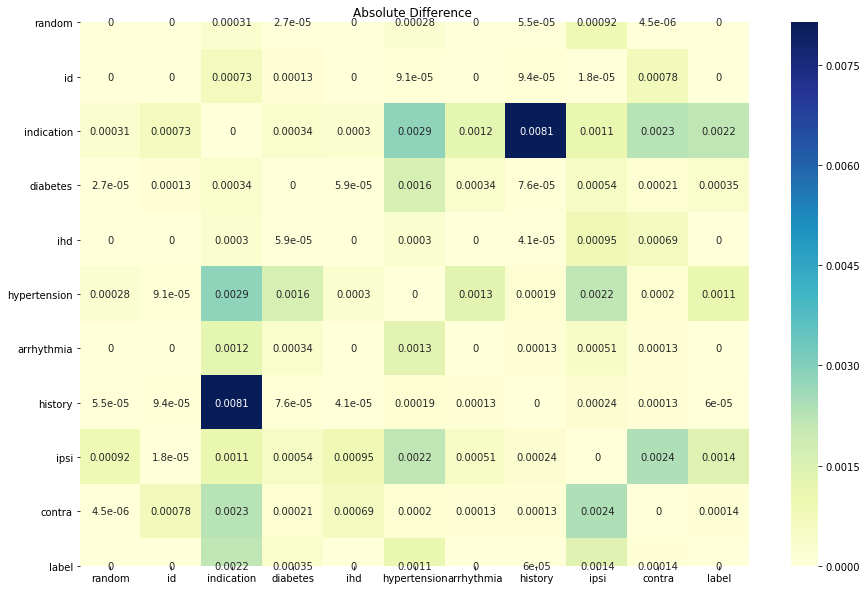

In [30]:
## Create a rough transform of categories to numeric values.
imputedTransformed = imputedDf.copy().replace(["Risk", "NoRisk", "yes", "no", "a-f", "asx", "tia", "cva"],[1,0,1,0,0,1,2,3])
transformed = correctedData.copy().replace(["Risk", "NoRisk", "yes", "no", "a-f", "asx", "tia", "cva", "nan"],[1,0,1,0,0,1,2,3, np.nan])

# Because we haven't imputed nans, we need to drop those rows for this comparison.
labelsUnknown = [475,523, 812,974,1418] ## Labels that were nan or "Unknown".
imputedTransformed = imputedTransformed.drop(labelsUnknown)
transformed = transformed.drop(labelsUnknown)

# Solve strange issue where label doesn't output to heatmap even though all vals are int 1 or 0.
imputedTransformed['label'] = imputedTransformed['label'].apply(lambda x: int(x))
transformed['label'] = transformed['label'].apply(lambda x: int(x))

plt.figure(figsize=(15,10))
plt.title("Absolute Difference ")
sns.heatmap(abs(imputedTransformed.corr() - transformed.corr()), annot=True, cmap="YlGnBu")



<br>

Even the biggest (hsitory:indication) **differences are not statistically significant** in terms of the pearson coefficient.

<br>

<p><b style="color: red">ACTION:</b> Continue analysis with the imputed inputs so that there are more data points.<p>

<hr>

## Distribution and Outliers
The following checks univariate and multivariate distribution for each feature to gain insight into the class balance, outliers and any other patterns.

In [31]:
# Drop the nan labels and unknown classifications from imputedDf
#.. they are imputed in another df (labelsImputed).
imputedDf = imputedDf.replace("Unknown", np.nan)
imputedDf = imputedDf.dropna()
imputedDf.info() # Should be 1515 records left with no nulls.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1515 entries, 0 to 1519
Data columns (total 11 columns):
random          1515 non-null float64
id              1515 non-null int64
indication      1515 non-null object
diabetes        1515 non-null object
ihd             1515 non-null object
hypertension    1515 non-null object
arrhythmia      1515 non-null object
history         1515 non-null object
ipsi            1515 non-null float64
contra          1515 non-null float64
label           1515 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 142.0+ KB


<br>

Make a dataframe of just the risk cases and just the norisk cases for comparisons. 

In [32]:
riskCases = imputedDf.copy()
riskCases = riskCases[riskCases["label"] == "Risk"]

noRiskCases = imputedDf.copy()
noRiskCases = noRiskCases[noRiskCases["label"] == "NoRisk"]

<hr>

**LABEL Distribution**

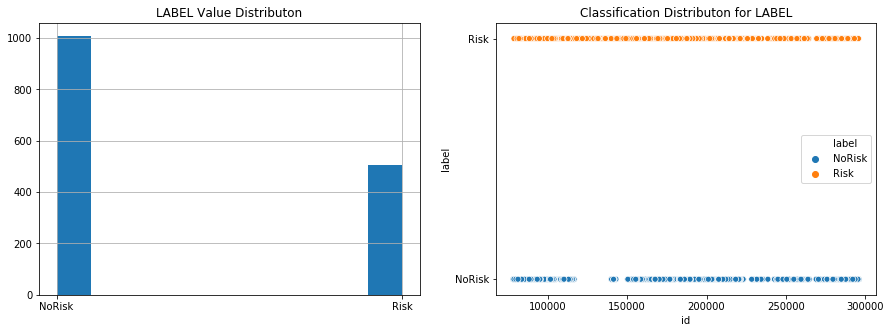

Classification distribution metrics:
Category: NoRisk
count       1008
unique         1
top       NoRisk
freq        1008
Name: label, dtype: object
% of most frequent (NoRisk): 100.0

Category: Risk
count      507
unique       1
top       Risk
freq       507
Name: label, dtype: object
% of most frequent (Risk): 100.0



In [33]:
PlotDist(imputedDf,"label", categoric=True)

The distribution of our target class is somewhat imbalanced, with approximately 1/3rd of the cases being positive (at risk).

This is an important detail to consider when splitting the training and testing sets, as the imbalance could be exacerbated and lead to unpredictable performance. 

Similarly, extra attention will need to be given to performance metrics, since the null error rate will be around 70%.

One other thing that stands out is the gap in the scatter plot, in the norisk part.


<br>

<p><b style="color: red">ACTION:</b> Use stratified methods in creating train-test splits and be wary of null-error rate.<p>
    
<br>


**ID Distribution**

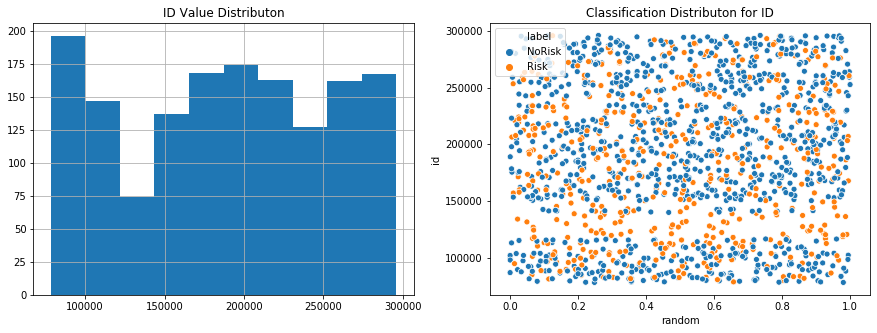

In [34]:
PlotDist(imputedDf,"id", "random", categoric=False)

This distribution highlights some odd things.

- id appears bi or tri modal, from the histogram.
- There's a distinct cluster of risk cases in the scatterpolot (explaining the gap mentioned in the previous section).
- This cluster is actually quite sparse, suggesting the no-risk cases might even be missing.

Once again the question of what this id feature actually is -is raised. 

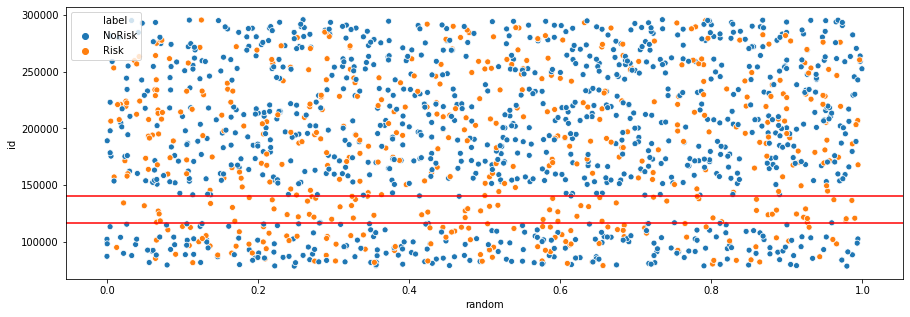

In [35]:
plt.figure(figsize=(15,5))
plt.axhline(y=139960, color="red") # Draw on the plot to highlight the cluster.
plt.axhline(y=116720, color="red")
sns.scatterplot(x="random", y="id", hue="label", data=imputedDf)

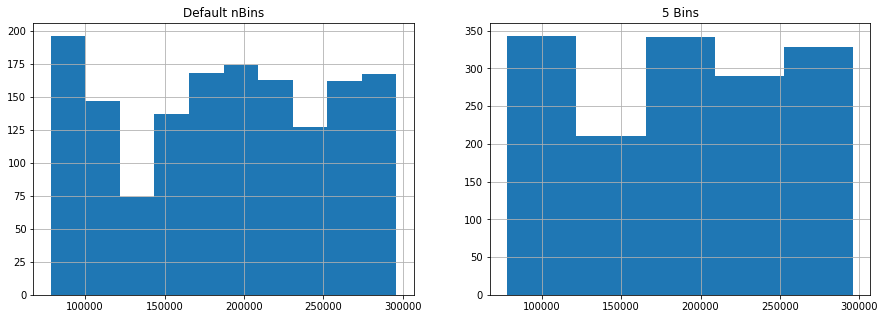

In [36]:
# Plot historgram with default number of bins.
plt.figure(figsize=(15,5))
plt.subplot(1,2,1, title="Default nBins")
imputedDf["id"].hist()

# Plot historgram with fewer bins.
plt.subplot(1,2,2, title="5 Bins")
imputedDf["id"].hist(bins=5)

Reducing the number of bins simplifies the visualisation and is more inline with the anticipated result. The distinct trough is of course caused by this sparse risk cluster.

In [37]:
# Get a the risk cluster as its own dataframe.
riskCluster = imputedDf.copy()
riskCluster = riskCluster[riskCluster["id"] > 116720]
riskCluster = riskCluster[riskCluster["id"] < 139960]
riskCluster

,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label
52,0.927099,116919,a-f,no,no,yes,yes,no,90.0,75.0,Risk
56,0.474349,121150,cva,no,yes,yes,no,no,70.0,100.0,Risk
58,0.474349,127162,cva,no,no,yes,yes,no,95.0,100.0,Risk
94,0.271620,139633,a-f,no,no,no,no,no,85.0,100.0,Risk
97,0.268116,124044,tia,no,yes,yes,yes,no,75.0,50.0,Risk
...,...,...,...,...,...,...,...,...,...,...,...
1430,0.637741,130804,tia,no,yes,no,no,no,90.0,100.0,Risk
1447,0.986147,136318,cva,no,yes,yes,no,no,70.0,100.0,Risk
1481,0.627473,131684,asx,no,no,yes,no,no,90.0,80.0,Risk
1514,0.070838,118228,asx,no,yes,yes,yes,no,70.0,100.0,Risk


With 66 records it could be a study group as part of a clincal trial, or it could be that rather than id being the missing session feature, it's the record used to SORT as was expected of the random column.

We can try removing this cluster to see if it has any significant effects on the correlation of features.

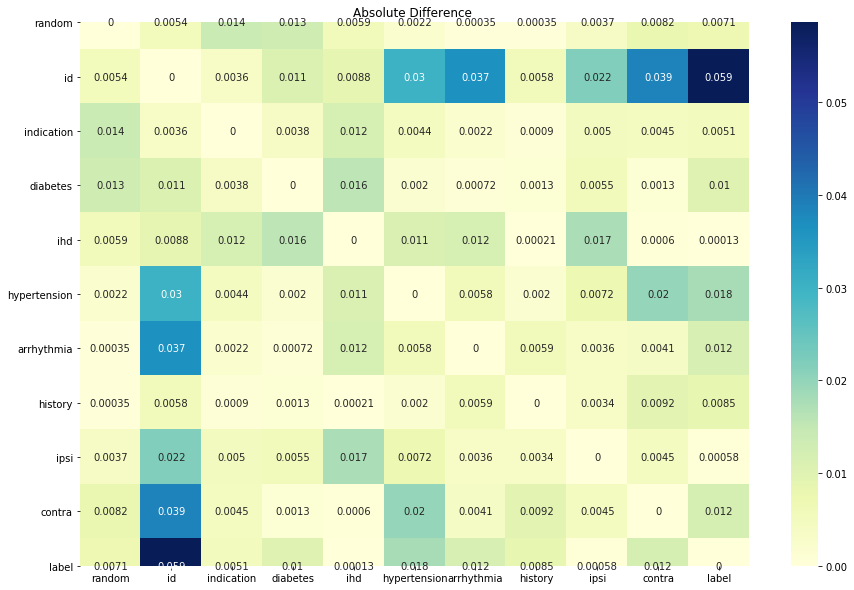

In [38]:
imputedPlot = imputedDf.copy() # Copy of df for plotting.
noRiskCluster = imputedDf.copy()  # Copy of df to remove cluster from.
indexes = riskCluster.index.values
noRiskCluster = noRiskCluster.drop(indexes)

# Temporarily transform data to plot it on heatmap.
noRiskCluster = noRiskCluster.replace(["Risk", "NoRisk", "yes", "no", "a-f", "asx", "tia", "cva","nan"],[1,0,1,0,0,1,2,3, np.nan])
imputedPlot = imputedPlot.replace(["Risk", "NoRisk", "yes", "no", "a-f", "asx", "tia", "cva", "nan"],[1,0,1,0,0,1,2,3, np.nan])

# Solve strange issue where some cols don't output to heatmap even though all vals are int 1 or 0.
for col in rawColNames:
    noRiskCluster[col] = noRiskCluster[col].apply(lambda x: float(x))
    imputedPlot[col] = imputedPlot[col].apply(lambda x: float(x))

plt.figure(figsize=(15,10))
plt.title("Absolute Difference ")
sns.heatmap(abs(noRiskCluster.corr() - imputedPlot.corr()), annot=True, cmap="YlGnBu")

Removing the cluster doesn't cause any *significant* changes in feature correlation interestingly. The most significant changes are in relation to the id feature itself, which is being scrutinised.

<br>


<p><b style="color: red">ACTION:</b> Trial models with and without the risk cluster.<p>

<hr>

**RANDOM Distribution**

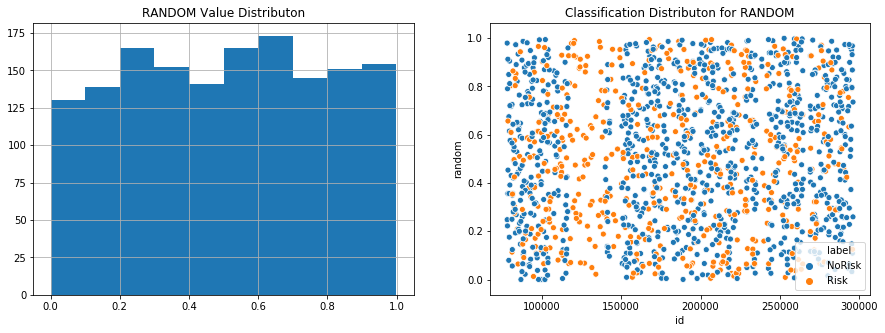

In [39]:
PlotDist(imputedDf,"random", categoric=False)

Random actually seems to adhere to it's name here, though the plateu also supports the ongoing suggestion that it could be a patient identifier. 

Viewing this histrogram with less and more bins may highlight some hidden information.

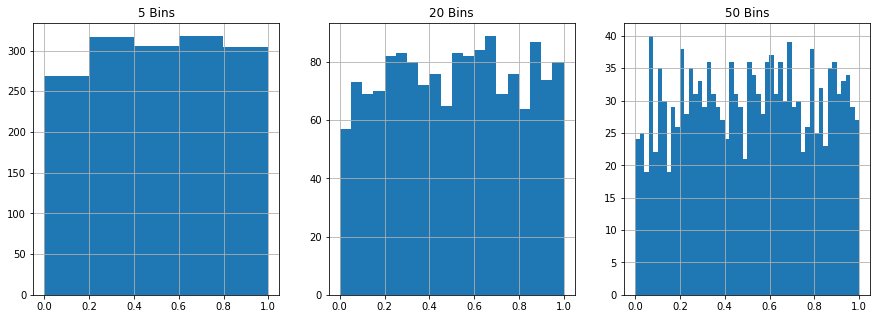

In [40]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1, title="5 Bins")
imputedDf["random"].hist(bins=5)
plt.subplot(1,3,2, title="20 Bins")
imputedDf["random"].hist(bins=20)
plt.subplot(1,3,3, title="50 Bins")
imputedDf["random"].hist(bins=50)

There looks to be some soft, irregular modals but nothing significant. Ultimately **random will probably be dropped from the training set**.

<hr>

**INDICATION Distribution**

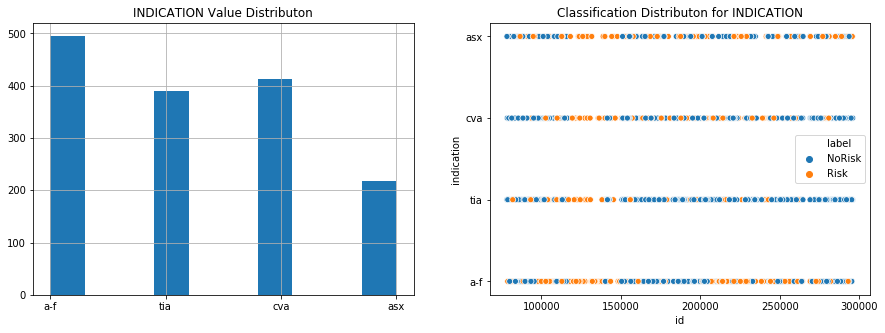

Classification distribution metrics:
Category: a-f
count        495
unique         2
top       NoRisk
freq         290
Name: label, dtype: object
% of most frequent (NoRisk): 58.59

Category: tia
count        390
unique         2
top       NoRisk
freq         326
Name: label, dtype: object
% of most frequent (NoRisk): 83.59

Category: cva
count        413
unique         2
top       NoRisk
freq         279
Name: label, dtype: object
% of most frequent (NoRisk): 67.55

Category: asx
count        217
unique         2
top       NoRisk
freq         113
Name: label, dtype: object
% of most frequent (NoRisk): 52.07



In [41]:
PlotDist(imputedDf,"indication")

The "NoRisk" class is the most frequent classification in all 4 indication types.

Whilst a-f and asx are relatively close to 50:50 ratio (norisk:risk), cva and tia seem are less balanced, suggesting that these indications might **reduce** the chance a person is at risk.

This is interesting considering cva is and tia are cardiac arrest and tia; but the reasoning may be that a person who has experienced these episodes is less likely to experience them again.

Since asx and a-f are almost even splits, it might be viable to binarise this feature (e.g. cva/tia = 0, asx/a-f = 1).

<br>

<p><b style="color: red">ACTION:</b> Trial models with binarised indication: patients with cva or tia appear to have reduced risk.<p>

<hr>

**Diabetes Distribution**

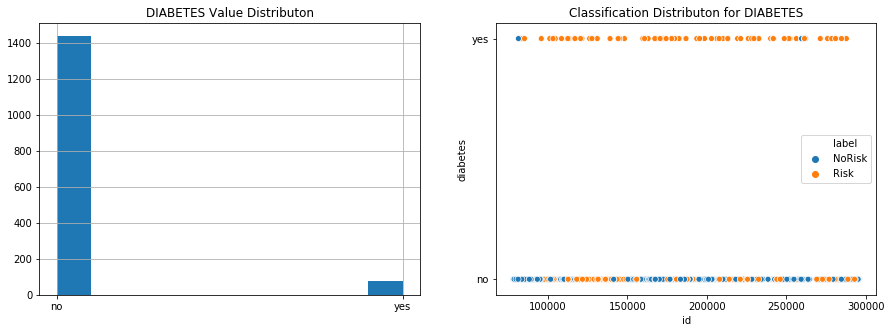

Classification distribution metrics:
Category: no
count       1439
unique         2
top       NoRisk
freq        1002
Name: label, dtype: object
% of most frequent (NoRisk): 69.63

Category: yes
count       76
unique       2
top       Risk
freq        70
Name: label, dtype: object
% of most frequent (Risk): 92.11



In [42]:
PlotDist(imputedDf,"diabetes")

Although the majority of diabetics are classified as being at risk (92.11%), diabetics are very poorly represented within the dataset, to the extent that non-diabetics have more patients classified as at risk (437).

<br>

<p><b style="color: red">ACTION:</b> Diabetes should be removed from the input data.<p>

**IHD Distribution**

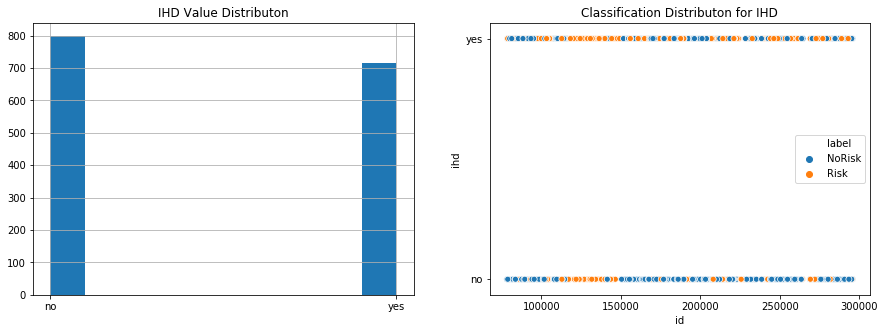

Classification distribution metrics:
Category: no
count        799
unique         2
top       NoRisk
freq         621
Name: label, dtype: object
% of most frequent (NoRisk): 77.72

Category: yes
count        716
unique         2
top       NoRisk
freq         387
Name: label, dtype: object
% of most frequent (NoRisk): 54.05



In [43]:
PlotDist(imputedDf,"ihd")

These plots and stats demonstrate that there is a relative increase in risk when the ihd feature is equal to 'yes', when compared to it being 'no'. However, it's almost a 50:50 split even then.

This suggests that IHD by itself is not a strong predictor for risk, but it may be useful in tandem with other features, which is explored below.

To explore this, **the following code isolates instances of ihd: yes**, in both the risk and no risk cases, for comparison. The idea is that distinct differences might indicate features that, combined with ihd, increase risk.

In [44]:
riskCases[riskCases["ihd"] == "yes"].describe(include="all")

,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label
count,329.000000,329.000000,329,329,329,329,329,329,329.000000,329.000000,329
unique,NaN,NaN,4,2,1,2,2,2,NaN,NaN,1
top,NaN,NaN,a-f,no,yes,yes,yes,no,NaN,NaN,Risk
freq,NaN,NaN,129,289,329,262,202,327,NaN,NaN,329
mean,0.489631,177337.671733,NaN,NaN,NaN,NaN,NaN,NaN,84.775076,79.990881,NaN
std,0.284871,59488.881286,NaN,NaN,NaN,NaN,NaN,NaN,8.821978,23.174903,NaN
min,0.005312,78745.000000,NaN,NaN,NaN,NaN,NaN,NaN,70.000000,10.000000,NaN
25%,0.267247,123618.000000,NaN,NaN,NaN,NaN,NaN,NaN,75.000000,55.000000,NaN
50%,0.479056,174588.000000,NaN,NaN,NaN,NaN,NaN,NaN,90.000000,90.000000,NaN
75%,0.704022,221214.000000,NaN,NaN,NaN,NaN,NaN,NaN,90.000000,100.000000,NaN


In [45]:
noRiskCases[noRiskCases["ihd"] == "yes"].describe(include="all")

,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label
count,387.000000,387.00000,387,387,387,387,387,387,387.000000,387.000000,387
unique,NaN,NaN,4,2,1,2,2,2,NaN,NaN,1
top,NaN,NaN,tia,no,yes,no,no,no,NaN,NaN,NoRisk
freq,NaN,NaN,122,381,387,252,382,385,NaN,NaN,387
mean,0.497985,188171.49354,NaN,NaN,NaN,NaN,NaN,NaN,75.599483,43.625323,NaN
std,0.278690,64485.78632,NaN,NaN,NaN,NaN,NaN,NaN,6.596223,21.236192,NaN
min,0.000616,78484.00000,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,10.000000,NaN
25%,0.259098,142854.50000,NaN,NaN,NaN,NaN,NaN,NaN,70.000000,20.000000,NaN
50%,0.500822,192129.00000,NaN,NaN,NaN,NaN,NaN,NaN,76.000000,45.000000,NaN
75%,0.722785,242907.00000,NaN,NaN,NaN,NaN,NaN,NaN,80.000000,60.000000,NaN


This works particularly well becausue of the near 50:50 split of ihd-postive records in both risk and no risk cases.

Focusing on the "mean" and "top" statistics in both tables, it can be seen that **NoRisk** cases of positive hypertension and arrhythmia are negative ("no"), as well as the mean value of contra being significantly less and the most frequent indication being tia (rather than a-f). Also of note is ipsi, whose range appears much less than contra's, so the smaller change from 85% to 75% is actually quite significant. 

This doesn't necessarily make ihd a valuable feature; those others may be more significant - **particularly arrhythmia which flips almost completely between classifications**. But it can be considered as other features are explored.


<br>


<p><b style="color: red">ACTION:</b> IHD appears to correlate to risk when arrhythmia and hypertension are also positive, contra is high, and indication is a-f.<p>

<hr>

**HYPERTENSION Distribution**

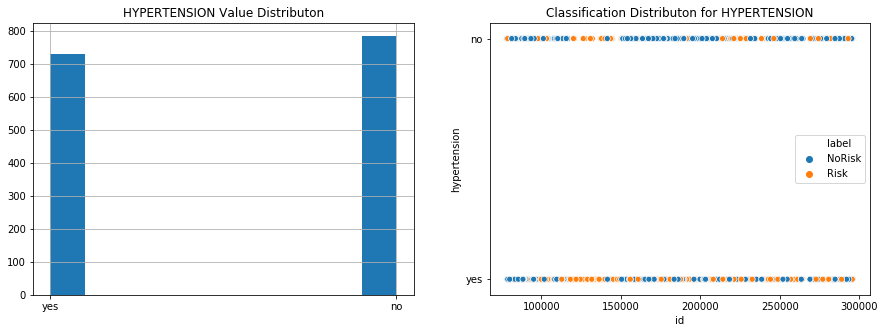

Classification distribution metrics:
Category: yes
count      730
unique       2
top       Risk
freq       382
Name: label, dtype: object
% of most frequent (Risk): 52.33

Category: no
count        785
unique         2
top       NoRisk
freq         660
Name: label, dtype: object
% of most frequent (NoRisk): 84.08



In [46]:
PlotDist(imputedDf,"hypertension")

These plots and stats read very similar to the IHD feature.

They demonstrate that there is a relative increase in risk when the  feature is equal to 'yes', when compared to it being 'no'. However, it's almost a 50:50 split even then.

This suggests that by itself is not a strong predictor for risk, but it may be useful in tandem with other features, which is explored below, as before.

In [47]:
riskCases[riskCases["hypertension"] == "yes"].describe(include="all")

,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label
count,382.000000,382.000000,382,382,382,382,382,382,382.000000,382.000000,382
unique,NaN,NaN,4,2,2,1,2,1,NaN,NaN,1
top,NaN,NaN,cva,no,yes,yes,yes,no,NaN,NaN,Risk
freq,NaN,NaN,124,324,262,382,241,382,NaN,NaN,382
mean,0.488160,179541.866492,NaN,NaN,NaN,NaN,NaN,NaN,84.507853,80.905759,NaN
std,0.289388,60423.320480,NaN,NaN,NaN,NaN,NaN,NaN,9.225873,21.526192,NaN
min,0.005312,80124.000000,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,10.000000,NaN
25%,0.245544,123620.000000,NaN,NaN,NaN,NaN,NaN,NaN,75.000000,66.250000,NaN
50%,0.480165,178642.500000,NaN,NaN,NaN,NaN,NaN,NaN,90.000000,90.000000,NaN
75%,0.722920,228280.250000,NaN,NaN,NaN,NaN,NaN,NaN,90.000000,100.000000,NaN


In [48]:
noRiskCases[noRiskCases["hypertension"] == "yes"].describe(include="all")

,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label
count,348.000000,348.000000,348,348,348,348,348,348,348.000000,348.000000,348
unique,NaN,NaN,4,2,2,1,2,2,NaN,NaN,1
top,NaN,NaN,tia,no,no,yes,no,no,NaN,NaN,NoRisk
freq,NaN,NaN,132,342,213,348,340,344,NaN,NaN,348
mean,0.518482,194265.988506,NaN,NaN,NaN,NaN,NaN,NaN,74.655172,37.525862,NaN
std,0.277660,65488.426670,NaN,NaN,NaN,NaN,NaN,NaN,7.821241,20.974031,NaN
min,0.004416,78447.000000,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,10.000000,NaN
25%,0.297598,152297.250000,NaN,NaN,NaN,NaN,NaN,NaN,70.000000,20.000000,NaN
50%,0.535056,195619.500000,NaN,NaN,NaN,NaN,NaN,NaN,75.000000,30.000000,NaN
75%,0.758415,252235.250000,NaN,NaN,NaN,NaN,NaN,NaN,80.000000,50.000000,NaN


These results mirror the deep-dive into IHD.

In the same way, arrhythmia, ipsi and contra change quite dramatically, along with IHD and the mode indication.  

<br>

<p><b style="color: red">ACTION:</b> hypertension appears to correlate to risk when arrhythmia and ihd are also positive and contra is high.<p>

<hr>

**ARRHYTHMIA Distribution**

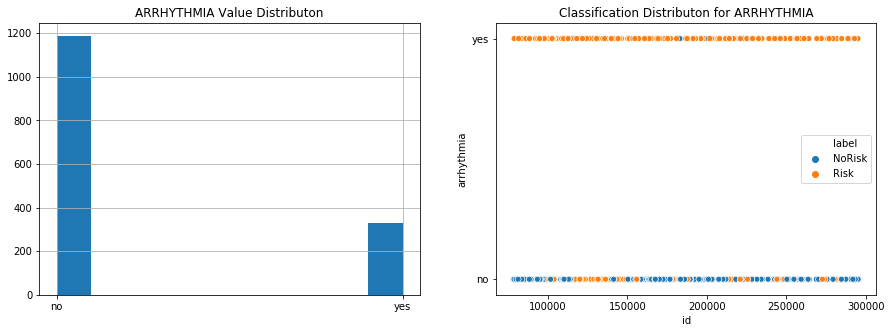

Classification distribution metrics:
Category: no
count       1187
unique         2
top       NoRisk
freq         998
Name: label, dtype: object
% of most frequent (NoRisk): 84.08

Category: yes
count      328
unique       2
top       Risk
freq       318
Name: label, dtype: object
% of most frequent (Risk): 96.95



In [49]:
PlotDist(imputedDf,"arrhythmia")

The data above shows that there's a 16% chance a patient is at risk when they don't have arrhythmia, and a 96% chance they are at risk if they do. Although not as severe as diabetes, there is still a significant class imbalance here.

Firstly, an initial check is in order: during the business understanding phase it was found that **patients with arterial fibrillation (indication: a-f) should also be documented as having arrhythmia**, because a-f *IS* an arrhythmia. 

In [50]:
tempAr = imputedDf.copy()
tempAr = tempAr[tempAr["indication"] == "a-f"] 
tempAr[tempAr["arrhythmia"] == "no"]

,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label
0,0.602437,218242,a-f,no,no,yes,no,no,78.0,20.0,NoRisk
2,0.602437,106066,a-f,no,yes,yes,no,no,95.0,40.0,Risk
6,0.383408,196122,a-f,no,yes,yes,no,no,90.0,95.0,Risk
11,0.655217,271863,a-f,no,yes,yes,no,no,80.0,40.0,Risk
12,0.071533,274906,a-f,no,yes,no,no,no,76.0,50.0,NoRisk
...,...,...,...,...,...,...,...,...,...,...,...
1486,0.313941,95434,a-f,no,no,no,no,no,90.0,50.0,NoRisk
1502,0.636996,176877,a-f,no,no,no,no,no,74.0,50.0,NoRisk
1505,0.720470,80002,a-f,no,yes,yes,no,no,80.0,10.0,NoRisk
1515,0.391440,93406,a-f,no,yes,no,no,no,76.0,60.0,NoRisk


If the business understanding is correct, this is quite a significant set of errors (376). The number of records supposedly misclassified raises the question of whether it is actually an error.

For peace of mind, the effect of re-classifying a-f sufferers as having an arrhythmia can be explored.

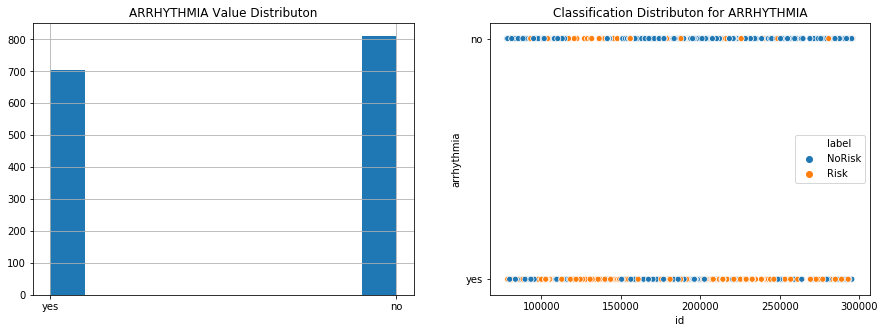

Classification distribution metrics:
Category: yes
count      704
unique       2
top       Risk
freq       404
Name: label, dtype: object
% of most frequent (Risk): 57.39

Category: no
count        811
unique         2
top       NoRisk
freq         708
Name: label, dtype: object
% of most frequent (NoRisk): 87.3



In [51]:
tempAr = imputedDf.copy()
for index, row in tempAr.iterrows():
    if row["indication"] == "a-f":
        tempAr.at[index, "arrhythmia"] = "yes"

PlotDist(tempAr,"arrhythmia")

This rebalances the class quite significantly, although it doesn't particularly help with the separation of risk and norisk cases.

This suggests that, since there different types of arrhythmia, and sine including a-f dilutes the separation (of risk and norisk), that the distinction is intended.

Some additional reading finds that there is a distinction between atrial fibrillations and ventrical fibrillations, with the latter being more severe (https://www.texasheart.org/heart-health/heart-information-center/topics/categories-of-arrhythmias/).


<br>

<p><b style="color: red">ACTION:</b> Arrhythmia is imbalanced but seems like a good combined feature: DON'T convert a-f.<p>

<hr>

**HISTORY Distribution**

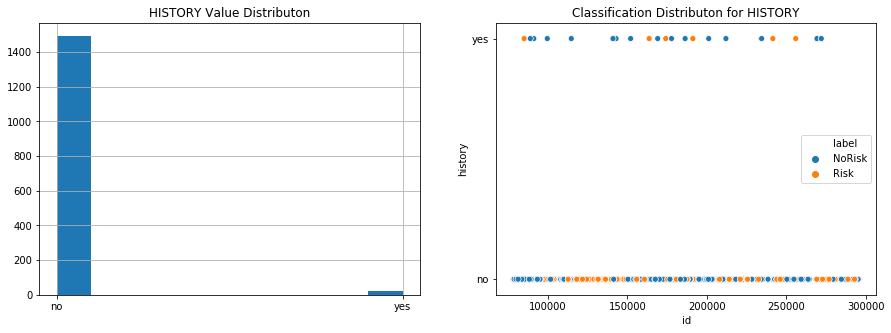

Classification distribution metrics:
Category: no
count       1492
unique         2
top       NoRisk
freq         993
Name: label, dtype: object
% of most frequent (NoRisk): 66.55

Category: yes
count         23
unique         2
top       NoRisk
freq          15
Name: label, dtype: object
% of most frequent (NoRisk): 65.22



In [52]:
PlotDist(imputedDf,"history")

This feature is incredibly imbalanced, even more-so than diabetes, and the class split is weak too.


<br>

<p><b style="color: red">ACTION:</b> Don't use history.<p>

<hr>

**IPSI Distribution**

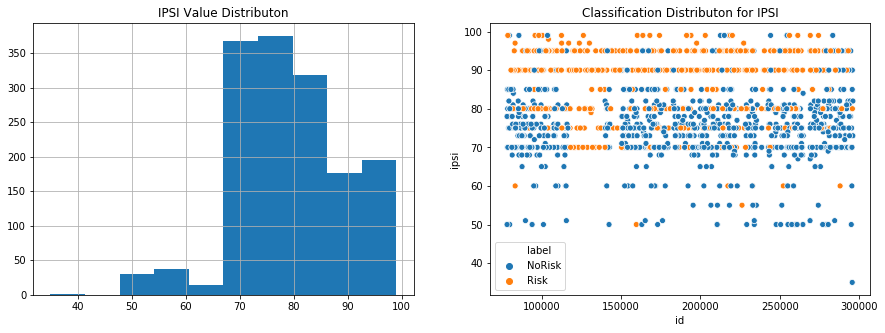

In [53]:
PlotDist(imputedDf,"ipsi", categoric=False)

Here we see a potential, negative effect of NOT removing the id cluster that was discovered earlier. Where there is otherwise a good class seperation between lower and higher ipsi values, there is a distinct vertical column of patients at risk with disregard for this pattern.

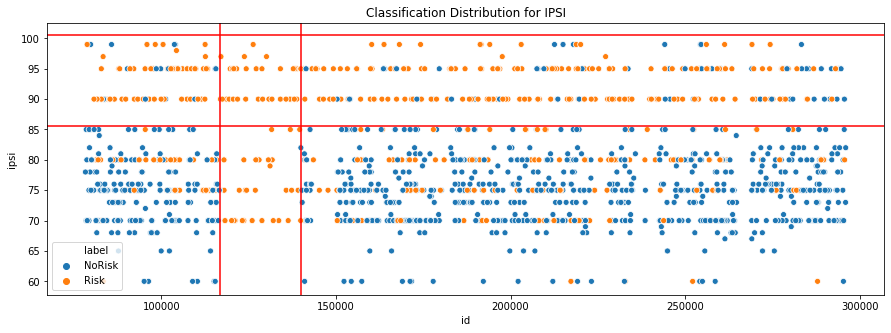

In [54]:
tempDf = imputedDf.copy()
ipsiFocus = tempDf[tempDf["ipsi"] > 55] # Selected by observing histogram xaxis.

# Highlight clustering.
plt.figure(figsize=(15,5))
plt.axhline(y=85.5, color="red")
plt.axhline(y=100.5, color="red")
plt.axvline(x=116720, color="red")
plt.axvline(x=139960, color="red")

plt.title("Classification Distribution for IPSI")
sns.scatterplot(x="id", y="ipsi", hue="label", data=ipsiFocus)

There does however, appear to be some subtle pattern to the occurrences of risk cases (at regular intervals: 70, 75, 80). Therefore, although the visualisation essentuates the cluster, the vertical cluster values aren't abnormal.

The clearest information is that **higher ipsi values seem to correlate with increased risk**.

Also, the **right-skewed distribution in the histogram suggests poor sampling**, since lower values do exist. Although these could be outliers, especially the "Risk" cases with lower ipsi scores, this **could be problematic when new data is introduced**, as we have a poor representation of real world values.

Considering this more closely, we can look to see what is considered an outlier in this data.

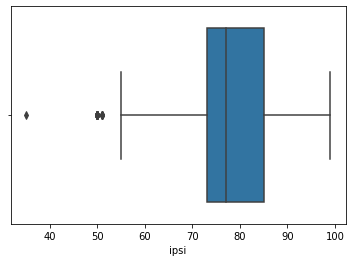

In [55]:
sns.boxplot(imputedDf["ipsi"])

In [56]:
ipsi = imputedDf[imputedDf["ipsi"] < 55] # 55 selected by observing boxplot.
print(str(len(ipsi)) + " potential outliers:")
ipsi

31 potential outliers:


,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label
26,0.616346,142470,cva,no,no,yes,no,no,50.0,40.0,NoRisk
99,0.897747,255097,a-f,no,no,yes,no,no,50.0,30.0,NoRisk
140,0.084495,233884,cva,no,no,yes,no,no,50.0,40.0,NoRisk
171,0.787587,279010,cva,no,no,yes,no,no,50.0,40.0,NoRisk
302,0.080884,159615,tia,yes,no,yes,no,no,50.0,100.0,Risk
328,0.208271,210672,tia,no,no,no,no,no,50.0,40.0,NoRisk
351,0.797398,294939,cva,no,no,no,no,no,50.0,50.0,NoRisk
392,0.673854,276966,cva,no,no,no,no,no,50.0,50.0,NoRisk
400,0.868120,295540,tia,no,no,no,no,no,35.0,35.0,NoRisk
418,0.396298,259748,cva,no,no,no,no,no,50.0,50.0,NoRisk


In [57]:
ipsi.describe(include="all")

,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label
count,31.000000,31.000000,31,31,31,31,31,31,31.000000,31.000000,31
unique,NaN,NaN,4,2,2,2,1,1,NaN,NaN,2
top,NaN,NaN,tia,no,no,no,no,no,NaN,NaN,NoRisk
freq,NaN,NaN,13,30,30,18,31,31,NaN,NaN,30
mean,0.474196,207511.903226,NaN,NaN,NaN,NaN,NaN,NaN,49.741935,48.709677,NaN
std,0.291030,70990.596261,NaN,NaN,NaN,NaN,NaN,NaN,2.768486,20.557551,NaN
min,0.063159,78261.000000,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,30.000000,NaN
25%,0.218118,161366.500000,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,40.000000,NaN
50%,0.456056,233870.000000,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,40.000000,NaN
75%,0.716200,262679.500000,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,51.000000,NaN


The most questionable records from the selection of "outliers" are the ones with contra values at 100 - one of which happens to be the only "risk" case as well - and the ipsi value of 35.

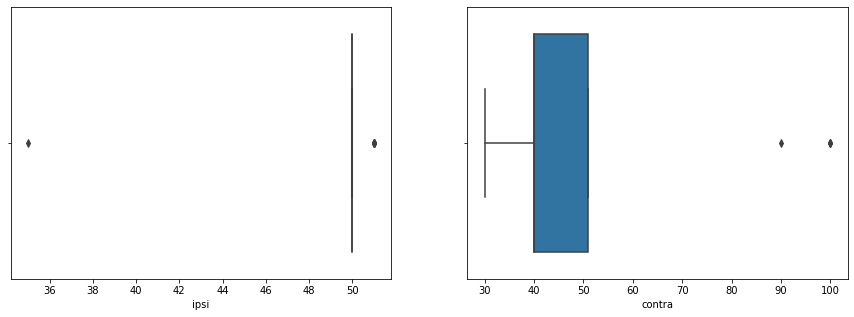

In [58]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.boxplot(ipsi["ipsi"]) ## Plot just the outlier group.

plt.subplot(1,2,2)
sns.boxplot(ipsi["contra"]) ## Plot just the outlier group.

Contra will be looked at independently, before action is taken, but the ipsi value is too far removed from the available distribution.

**The safest action overall may be to remove ipsi as a feature all-together.**


<br>

<p><b style="color: red">ACTION:</b> Possible outliers in ipsi, notably the record at index 400. Trial/evaluate value of ipsi in models.<p>

<hr>

**CONTRA Distribution**

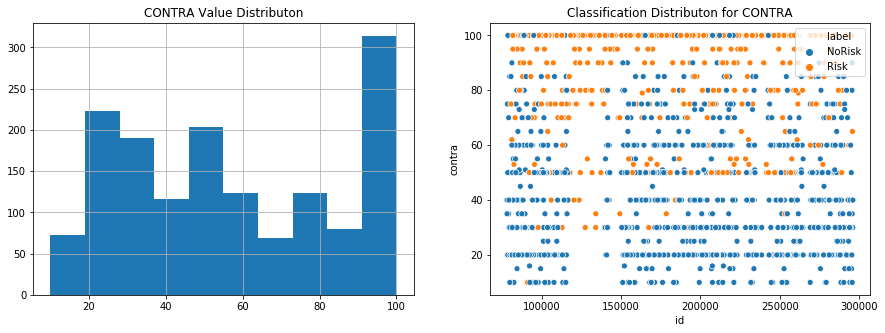

In [59]:
PlotDist(imputedDf,"contra", categoric=False)

The histogram here resembles something like a bi-modal distribution, which might be emphasised by reducing the number of bins. The scatter plot suggests that "risk" cases are more prevalent when contra is higher.

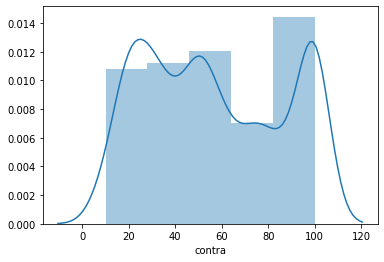

In [60]:
sns.distplot(imputedDf["contra"], bins=5)

The histogram emphasises the density of points at 100%, which disrupts the more, left-skewed distribution.

It's possible there are outliers hidden there, particularly the norisk cases, which could be attributed to human error (e.g. inputing 100 instead of 10).

The following code looks at the effect of making all norisk cases 10, rather than 100.

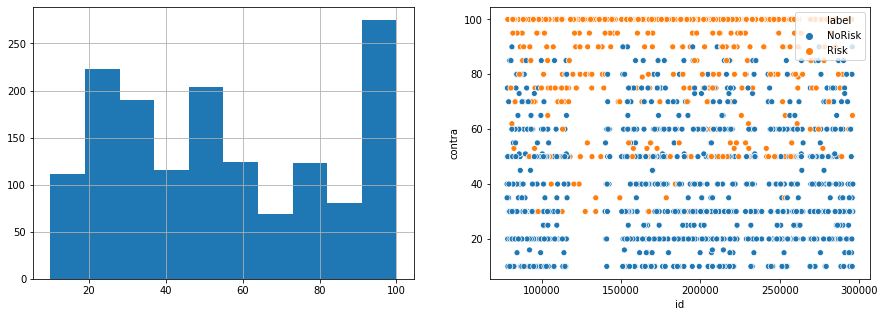

In [61]:
contra = imputedDf.copy()

## Set all contra values at 100 (that are classified as norisk) to 10.
for index, row in contra.iterrows():
    if row["label"] == "NoRisk" and row["contra"] == 100:# and row["ipsi"] < 90:
        contra.at[index, "contra"] = 10

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
contra["contra"].hist()
plt.subplot(1,2,2)
sns.scatterplot(x="id", y="contra", hue="label", data=contra)

This had little effect on the distribution, although it did slightly improve the class separation, so it's difficult to say from this alone if the data is incorrect.

We can plot the data as a boxplot and look at some statistics for an alternative perspective.

count    1515.000000
mean       56.776898
std        29.565933
min        10.000000
25%        30.000000
50%        50.000000
75%        85.000000
max       100.000000
Name: contra, dtype: float64

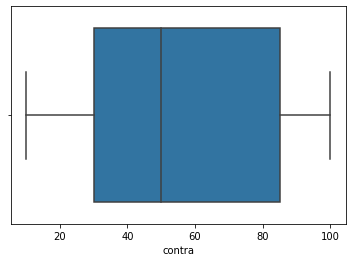

In [62]:
sns.boxplot(imputedDf["contra"])
imputedDf["contra"].describe()

There aren't any obvious outliers in contra although the standard deviation is quite high, which is visually represented in the sparsity of points as well. 

It could just be that contra isn't the most definitive indicator for risk.
<br>
<p><b style="color: red">ACTION:</b> Possible outliers in contra and sparse class seperation. Trial/evaluate value of contra in models.<p>
<br>

<hr>

### Other Checks
The following checks review any assumptions made in the business understanding phase that have not yet been explored, or other uncategorised checks.

<ul>
<li><s>Patients with an indication of "a-f" should also be be recorded as having an arrhythmia.</s>
</li>
<li><s>The indication feature almost appears ordinal, with a-f and asx being cause for cva and tia; although it is difficult to verify this without communicating with professionals.</s>
</li>
<li style="color:blue">Assuming IPSI and Contra are recorded at the same time in relation to the same stroke or event (and since IPSI is reffering to the percentage of lesions on the same side and Contra on the opposite side) it would make sense for the 2 values to have sum of 100%</li>
<ul>  

This point was more of an assumption than an understanding, and based off data inspection so far, it doesn't seem to be the case.

A quick visual check is to overlay the distributions of ipsi and contra - if  the pattern holds, ipsi should peak in contra troughs and vice versa.

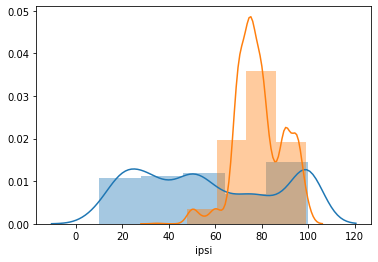

In [63]:
sns.distplot(imputedDf["contra"], bins=5)
sns.distplot(imputedDf["ipsi"], bins=5)

The assumption doesn't hold. We can also look at the sums of ipsi and contra to see if it EVER equals 100; if it doesn't then the chances are the assumption is totally wrong.

In [64]:
ar100 = [] # Record indexes that sum around 100.
for index, row in imputedDf.iterrows():
    sums = row["contra"] + row["ipsi"]
    if sums > 90 and sums < 110:
        ar100.append(index)
        
print(str(len(ar100)) + " records comply")

294 records comply


294 records out of 1500+ records sum *around* 100.

**In short, the ipsi:contra ratio is unlikely.**

<br>

<hr>

# 3. Data Preperation
This section collates the dataframes created in the data understanding and looks to make the optimal decisions and transformations in preparing them for modelling.

<hr>

## 3.1. Dataframes
This section gathers the different variations of the data in an object so that transformations etc. can be applied systematically.

Variations of the data will be based on the copy with imputed values, but a copy will also exist with the records DROPPED rather than imputed, for comparison.

In [65]:
## Create a storage object for all dataframes so that transformations can be applied to all of them.
dataframes = {}

In [66]:
## Copy of the data with values dropped, rather than imputed.
droppedData = correctedData.copy()
indexes = FindMissing(droppedData, rawColNames).index.values ## Get indexes of missing values.
droppedData = droppedData.drop(indexes) ## Drop missing values
indexes = droppedData[droppedData["label"] == "Unknown"].index.values ## Get indexes of "Unknown" classifications.
droppedData = droppedData.drop(indexes) ## Drop unknown classifications.

dataframes["droppedData"] = droppedData ## Add to dict.

18 records with missing values:


In [67]:
## Copy of the data with selected features.
imputedSelected = imputedDf.copy()
dataframes["imputedSelected"] = imputedSelected ## Add to dict.

In [68]:
## Copy of the data with imputed values, including labels, with selected features.
dataframes["labelsImputedSelected"] = labelsImputed ## Add to dict.

In [69]:
## Copy of the data with selected features, with no IPSI.
imputedSelectedNoIpsi = imputedDf.copy()
dataframes["imputedSelectedNoIpsi"] = imputedSelectedNoIpsi ## Add to dict.

In [70]:
## Copy of the data with indication converted to a binary feature (a-f and asx == 1, cva and tia == 0).
indicationBinarised = imputedDf.copy()
dataframes["indicationBinarised"] = indicationBinarised ## Add to dict.

In [71]:
## Copy of the data with imputed values, where all features will be kept.
imputedAllFeatures = imputedDf.copy()
dataframes["imputedAllFeatures"] = imputedAllFeatures ## Add to dict.

In [72]:
## Copy of the data with dropped values, where all features will be kept.
droppedAllFeatures = droppedData.copy()
dataframes["droppedAllFeatures"] = droppedAllFeatures ## Add to dict.

<hr>

## 3.1. Transformation
This section transforms initial dataframes to be more managable and less complex for any models (e.g. via normalisation).

<br>

Since most of the features are binary (i.e. risk/norisk, yes/no) we can simply convert them to 1s and 0s. Alternatively, the fields could be 1-hot encoded with 'get_dummies' but this would increase the feature space by doubling the number of features.

We can also normalise the ipsi and contra columns to make the models processing simpler. Since they are both percentages with set boundaries of 0-100, the most robust option is to divide by 100, as normal normalising (e.g. min-max) based on the **given** data would limit the possible min and max in future data, because it doesn't cover the full range (0-100).

In [73]:
for key, value in dataframes.items():
    # Binarise binary categorics.
    dataframes[key] = dataframes[key].replace(["yes", "no", "Risk", "NoRisk"], [1, 0, 1, 0])

    # Normalise IPSI and Contra.
    dataframes[key]["contra"] = dataframes[key]["contra"]  / 100
    dataframes[key]["ipsi"] = dataframes[key]["ipsi"] / 100

    # Modify indicationsBinarised individually - every over variations will 1-hot encode.
    if key == "indicationBinarised":
        ## Binarise.
        dataframes[key] = dataframes[key].replace(["yes", "no", "Risk", "NoRisk", "asx", "a-f", "cva", "tia"], [1, 0, 1, 0, 1, 1, 0, 0])
    else:
        ## 1HE
        dataframes[key] = pd.concat([dataframes[key].drop("indication", axis=1), pd.get_dummies(dataframes[key]["indication"])], axis=1)

Check transformations applied correctly:

In [74]:
dataframes["indicationBinarised"].head(3)

,random,id,indication,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label
0,0.602437,218242,1,0,0,1,0,0,0.78,0.2,0
1,0.602437,159284,0,0,0,0,0,0,0.70,0.6,0
2,0.602437,106066,1,0,1,1,0,0,0.95,0.4,1


In [75]:
dataframes["droppedData"].head(3)

,random,id,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label,a-f,asx,cva,tia
0,0.602437,218242,0,0,1,0,0,0.78,0.2,0,1,0,0,0
1,0.602437,159284,0,0,0,0,0,0.70,0.6,0,0,0,0,1
2,0.602437,106066,0,1,1,0,0,0.95,0.4,1,1,0,0,0


<hr>

## 3.2. Feature Selection
This section selects features for training based on the data understanding and supports the decisions with automated methods.

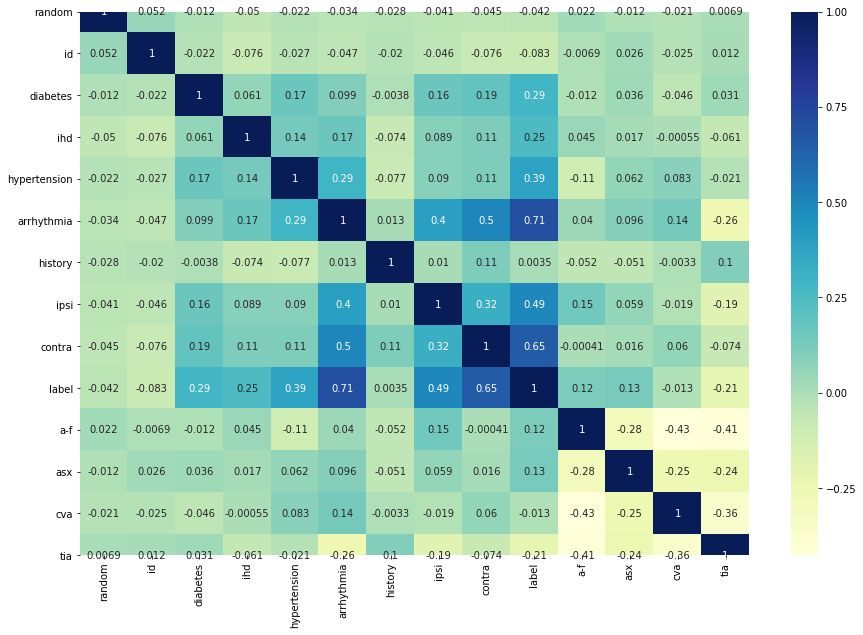

In [76]:
## Check correlations with 1he indication.
df = dataframes["imputedAllFeatures"].copy()
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

The slightly negative correlation between tia/cva and label supports what has been discussed about the two categories seemingly reducing risk (opposed to a-f and asx).

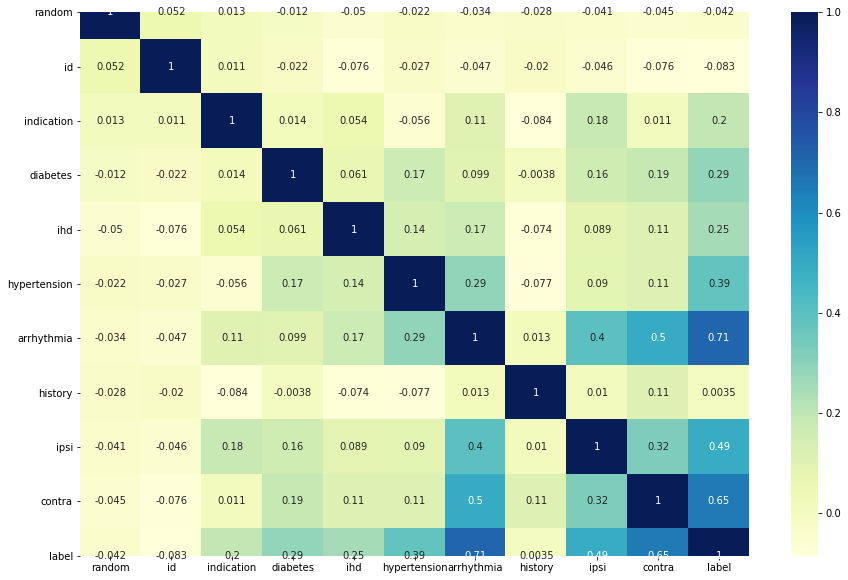

In [77]:
## Check correlations with binarised indication.
df = dataframes["indicationBinarised"].copy()
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

Visually, the difference is significant because the scale changes from -0.25:1.00 to 0.00:1.00 but there are no changes to the correlations between features and the label (beyond indication).

The second heatmap is much easier to interpret.

**Manual Selection**

The selection made here is based on the data understanding and supported by the heatmap above.

Columns to drop:

- id (unique, no correlation)
- random (mostly unique, no correlation)
- diabetes (massively imbalanced, low correlation)
- history (massively imbalanced, no correlation)

**IHD and indication** have relatively weak correlations to the label, and **may be worth dropping**, and recall that ipsi is a poor sample.

**Random Forest Selection**

Use feature weights from random forest to challenge the manual selection.

In [78]:
# Separate label and data from df.
data = df.drop(columns="label") ## Use binarised indication df from previous step.
labels = df["label"]

# Create random forest classifier. Max depth was decided by re-running; if id & random were scoring high, it was obviously overfitting.
model = rf(n_estimators=2000, max_depth=9)
fittedModel = model.fit(data,labels)

# Get feature scores.
featureNames = data.columns.values
importances = {}
for feature in zip(map(lambda x: round(x,4), fittedModel.feature_importances_), featureNames):
    importances[feature[1]] = feature[0] # Map score to feature name.

# Sort the scores (descending.)
importances = sorted(importances.items(), key=lambda kv: kv[1], reverse=True)

# Output
importances

[('arrhythmia', 0.3023),
 ('contra', 0.2983),
 ('ipsi', 0.1631),
 ('hypertension', 0.0787),
 ('ihd', 0.0355),
 ('diabetes', 0.0317),
 ('indication', 0.0301),
 ('id', 0.029),
 ('random', 0.0268),
 ('history', 0.0045)]

These rankings support the manual selection.

Diabetes ranks better than expected, but it is assumed that this is down to it's overly good class split (risk:norisk), despite the imbalance (yes:no). It will still be dropped because of the bias it would likely introduce.

**Feature Selection (Decision)**
Proceed with dropping:
- id
- random 
- diabetes 
- history

In [79]:
for key, value in dataframes.items():
    # Drop columns from data that won't use all features.
    if "AllFeatures" not in key:
        dataframes[key] = dataframes[key].drop(columns=["id","random", "diabetes", "history"])
        if key == "imputedSelectedNoIpsi":
            dataframes[key] = dataframes[key].drop(columns=["ipsi"]) ## Drop ipsi from one df.


In [80]:
dataframes["imputedSelected"].head(3) ## Output to confirm.        

,ihd,hypertension,arrhythmia,ipsi,contra,label,a-f,asx,cva,tia
0,0,1,0,0.78,0.2,0,1,0,0,0
1,0,0,0,0.70,0.6,0,0,0,0,1
2,1,1,0,0.95,0.4,1,1,0,0,0


In [81]:
dataframes["imputedAllFeatures"].head(3) ## Output to confirm.

,random,id,diabetes,ihd,hypertension,arrhythmia,history,ipsi,contra,label,a-f,asx,cva,tia
0,0.602437,218242,0,0,1,0,0,0.78,0.2,0,1,0,0,0
1,0.602437,159284,0,0,0,0,0,0.70,0.6,0,0,0,0,1
2,0.602437,106066,0,1,1,0,0,0.95,0.4,1,1,0,0,0


<hr>

## 3.3. Stratification (TTS)
This section compares and selects methods of splitting the training data.

**Data-driven Random TTS**

Create a stratified train-test split by attaining similar distributions of features in the train and test set.

**NB:** The next code cell was run with various random seeds until similar distributions in train and test data were achieved.

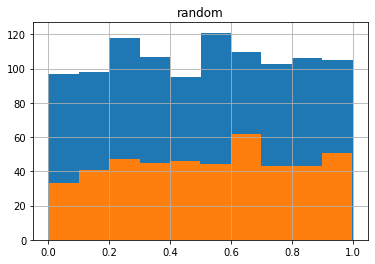

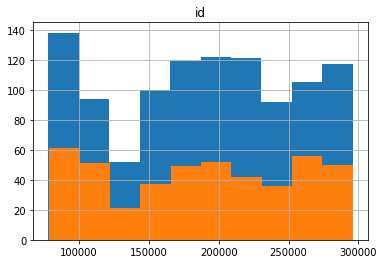

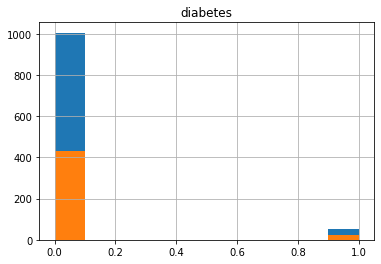

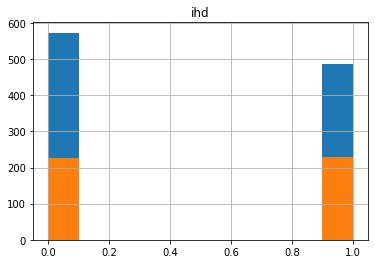

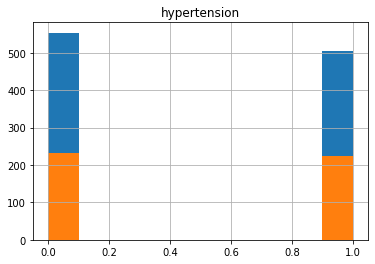

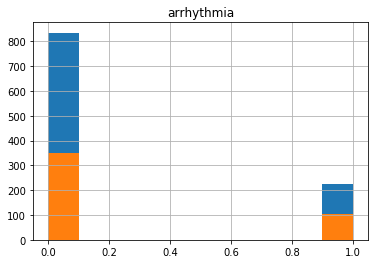

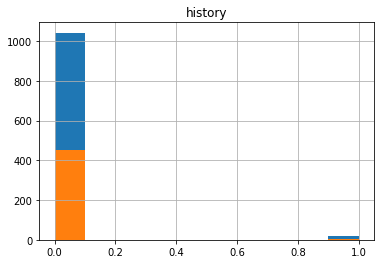

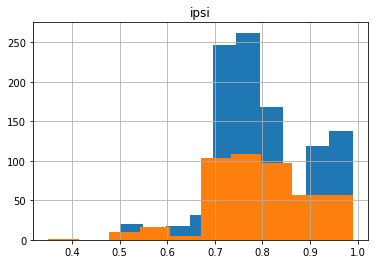

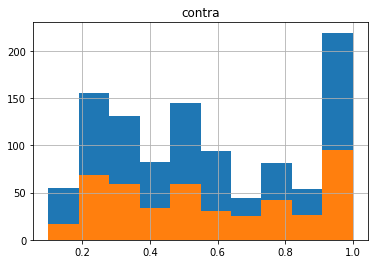

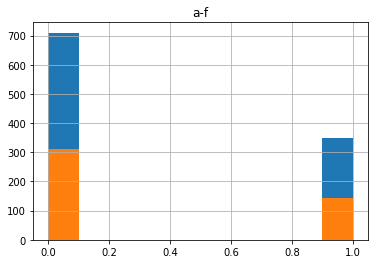

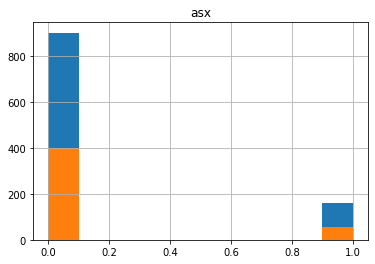

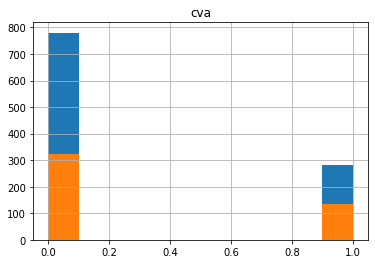

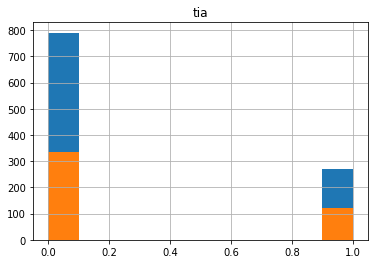

In [82]:
df = dataframes["imputedAllFeatures"].copy()
data = df.drop(columns="label")
labels = df["label"]
xtr, xte, ytr, yte = skl.model_selection.train_test_split(data, labels, shuffle=True, random_state=69, test_size=0.3)

# Compare distributions of train and test split.
for col in xtr.columns.values:
    plt.title(col)
    xtr[col].hist()
    xte[col].hist()
    plt.show()

This is a relatively good looking split with similar distributions.

**Stratified K-Fold**

Splitting the data into k-folds can reduce bias. Five folds has been selected to ensure that training sets aren't too small; when k=5, the test set is around 300 records, which is slightly lower than the ~450 obtained through a convention TTS.


In [83]:
## Split into x and y.
kf = StratifiedKFold(n_splits=5, shuffle=True)

## https://stackoverflow.com/questions/51852551/key-error-not-in-index-while-cross-validation
for train_index, test_index in kf.split(data,labels):
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    

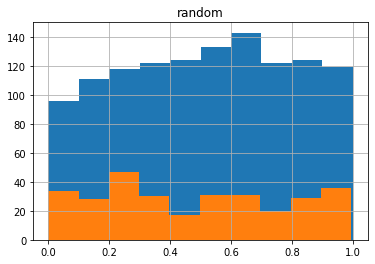

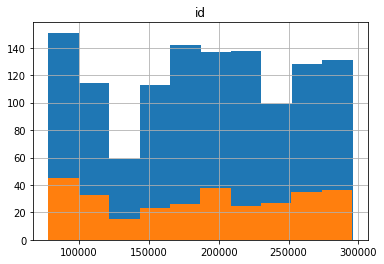

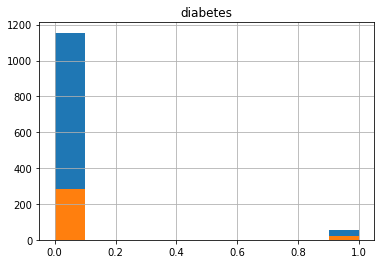

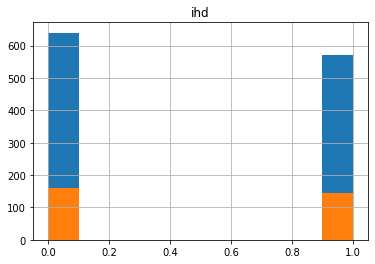

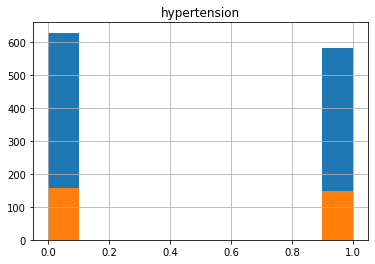

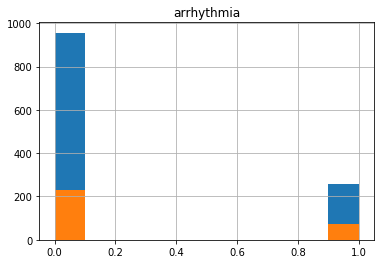

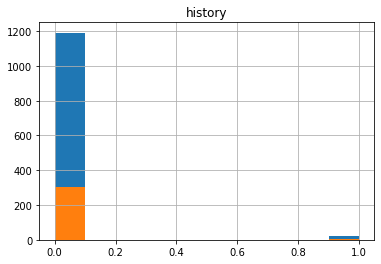

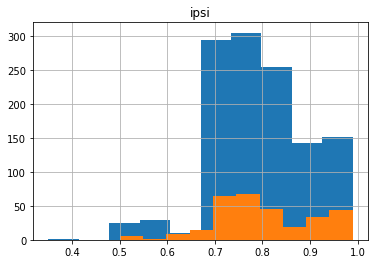

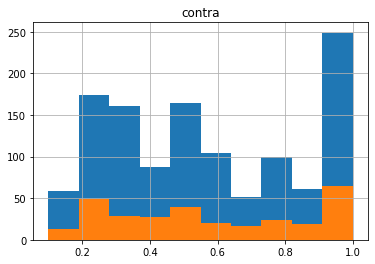

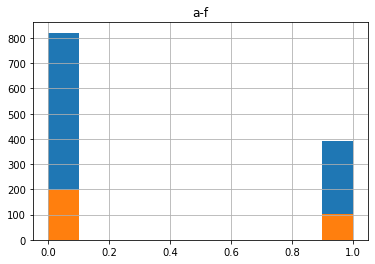

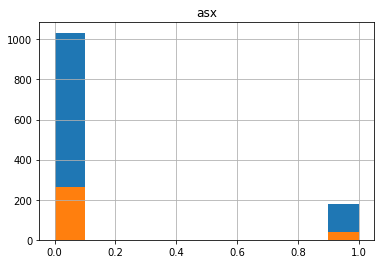

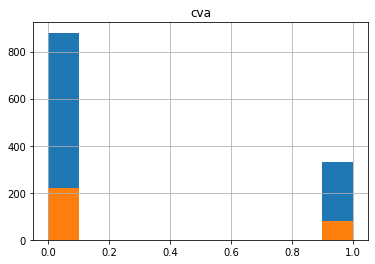

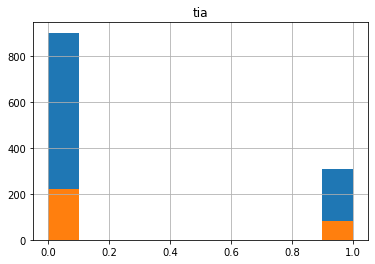

In [84]:
# Inspect distribution of a fold.
for col in X_train.columns.values:
    plt.title(col)
    X_train[col].hist()
    X_test[col].hist()
    plt.show()

The stratified k-fold distributions are even closer than the conventional TTS.

Since they allow greater use of the data and are known to reduce bias, I will use kfold validation to "score" the model and detect overfitting with the prediction on a TTS.

<hr>

# 4. Modelling
This section iteratively creates models from variations of the original dataset, based on results.

In [85]:
models = {} # Wrapper for models.

## 4.1. Baseline Model (Logistic Regression)
Create a simple model to get benchmarks and idea of best dataset to use.

In [86]:
# Create model in wrapper (set random_state for consistent results).
models["BASELINE (LRC)"] = LogisticRegression(random_state=1337)

<br>

The wrapper method defined in the utilities section outputs the all the performance metrics below, per model, per data set.

As described in the business understanding section, the metrics of most concern are sens and spec, for which the F1 score provides an overview.

In [87]:
TrainPred(models.items(),dataframes.items(), 5)

,Model,Data,KFold Avg,TP,FP,TN,FN,Acc,Spec (tpR),Sens (tnR),Prec,F1 Score
0,BASELINE (LRC),droppedData,0.946667,141,10,280,19,0.935556,0.965517,0.881250,0.933775,0.906752
2,BASELINE (LRC),labelsImputedSelected,0.945395,130,9,298,19,0.938596,0.970684,0.872483,0.935252,0.902778
1,BASELINE (LRC),imputedSelected,0.945875,139,14,285,17,0.931868,0.953177,0.891026,0.908497,0.899676
4,BASELINE (LRC),indicationBinarised,0.943234,137,13,286,19,0.929670,0.956522,0.878205,0.913333,0.895425
3,BASELINE (LRC),imputedSelectedNoIpsi,0.930693,135,14,285,21,0.923077,0.953177,0.865385,0.906040,0.885246
5,BASELINE (LRC),imputedAllFeatures,0.665347,0,0,299,156,0.657143,1.000000,0.000000,NaN,0.000000
6,BASELINE (LRC),droppedAllFeatures,0.717333,0,0,290,160,0.644444,1.000000,0.000000,NaN,0.000000


While the "droppedData" dataset acheived the best f1 score, it also has a reduced number of datapoints and therefore has a higher percentage of false predictions compared to the next best: "labelsImputedSelected".

Therefore, "labelsImputedSelected" will be used for further analysis for now.

To begin with, chheck if removing any of the other features which showed weaker correlation to the label can improve scores.

In [88]:
# Select best performing dataset/s.
bestDataframe = { "labelsImputedSelected": dataframes["labelsImputedSelected"]}

# Create some alternate sets based on those and feature selection findings.
noIHDorIndication = bestDataframe["labelsImputedSelected"].copy()
noIHDorIndication = noIHDorIndication.drop(columns=["ihd", "asx", "a-f", "cva", "tia"])
bestDataframe["noIHDorIndication"] = noIHDorIndication

# Drop ihd.
noIHD = bestDataframe["labelsImputedSelected"].copy()
noIHD = noIHD.drop(columns=["ihd"])
bestDataframe["noIHD"] = noIHD

# Drop indication.
noIndication = bestDataframe["labelsImputedSelected"].copy()
noIndication = noIndication.drop(columns=["asx", "a-f", "cva", "tia"])
bestDataframe["noIndication"] = noIndication

In [89]:
# Train on the new datasets with the baseline model.
TrainPred({"Basline": model}.items(),bestDataframe.items(), 5)

,Model,Data,KFold Avg,TP,FP,TN,FN,Acc,Spec (tpR),Sens (tnR),Prec,F1 Score
3,Basline,noIndication,0.980263,144,6,301,5,0.975877,0.980456,0.966443,0.960000,0.963211
0,Basline,labelsImputedSelected,0.984868,143,5,302,6,0.975877,0.983713,0.959732,0.966216,0.962963
2,Basline,noIHD,0.977632,140,4,303,9,0.971491,0.986971,0.939597,0.972222,0.955631
1,Basline,noIHDorIndication,0.956579,140,10,297,9,0.958333,0.967427,0.939597,0.933333,0.936455


Removing indication features reduces the number of false negatives, whilst removing ihd reduced the number of false positives. Considering the context of the use-case, reducing the number of false negatives will be prioritised. Therefore, the dataset carried forward will be the "noIndication" variation.

## 4.2. Additional Models with Selected Data

In [90]:
bestDataframe = { "chosenData": bestDataframe["noIndication"] }

Now there's an idea about the optimal datset, experiment with different types of models to see if the baseline performance can be improved (which is already quite substantial).

In [91]:
# Define various models with default hyperparemters
models["SVM-Baseline"] = svm.SVC(random_state=1337)
models["DecisionTree-Baseline"] = DecisionTreeClassifier(max_depth=10, random_state=1337) # Set max depth to avoid overfitting.
models["RandomForest-Baseline"] = rf(max_depth=10, random_state=1337) # Set max depth to avoid overfitting.
models["MLP-Baseline"] = mlp(random_state=1337)
models["KNeighbours-Baseline"] = KNeighborsClassifier()

In [92]:
# Train all the default model variations on the selected dataset. 
TrainPred(models.items(), bestDataframe.items(), 5)

,Model,Data,KFold Avg,TP,FP,TN,FN,Acc,Spec (tpR),Sens (tnR),Prec,F1 Score
3,RandomForest-Baseline,chosenData,0.978289,144,6,301,5,0.975877,0.980456,0.966443,0.960000,0.963211
2,DecisionTree-Baseline,chosenData,0.975000,143,7,300,6,0.971491,0.977199,0.959732,0.953333,0.956522
5,KNeighbours-Baseline,chosenData,0.955921,144,9,298,5,0.969298,0.970684,0.966443,0.941176,0.953642
1,SVM-Baseline,chosenData,0.944737,135,9,298,14,0.949561,0.970684,0.906040,0.937500,0.921502
0,BASELINE (LRC),chosenData,0.932895,132,10,297,17,0.940789,0.967427,0.885906,0.929577,0.907216
4,MLP-Baseline,chosenData,0.931579,130,9,298,19,0.938596,0.970684,0.872483,0.935252,0.902778


Whilst the KNeighbours classifer performaed almost as well as the decision tree and random forest, the latter performed better in cross validation suggesting they are more robust. Furthermore, the nature of decision trees makes them very transparent and explainable, which is hugely beneficial in this domain (healthcare).

Taking the random forest and decision tree forward, hyperparameters can be modified to see if performance can be improved further. In particular, different tree depths can be looked at -  although the baseline depth is only 10 there is still the chance they are overfitting.

## 4.3. Hyperparameter Tuning (selected model/s)

In [93]:
models = {}

# Find optimal tree depth from 5-15 (+-5 from baseline).
for depth in range (5, 16): # 5-15
    models["DT-D" + str(depth)] = DecisionTreeClassifier(max_depth=depth, random_state=1337)
    models["RF-D" + str(depth)] = rf(max_depth=depth, random_state=1337)

In [94]:
# Output metrics for random forests and decision trees with different max depths.
TrainPred(models.items(), bestDataframe.items(), 5)

,Model,Data,KFold Avg,TP,FP,TN,FN,Acc,Spec (tpR),Sens (tnR),Prec,F1 Score
11,RF-D10,chosenData,0.978289,144,6,301,5,0.975877,0.980456,0.966443,0.960000,0.963211
9,RF-D9,chosenData,0.978289,144,6,301,5,0.975877,0.980456,0.966443,0.960000,0.963211
19,RF-D14,chosenData,0.978947,144,6,301,5,0.975877,0.980456,0.966443,0.960000,0.963211
17,RF-D13,chosenData,0.978947,144,6,301,5,0.975877,0.980456,0.966443,0.960000,0.963211
15,RF-D12,chosenData,0.978947,144,6,301,5,0.975877,0.980456,0.966443,0.960000,0.963211
13,RF-D11,chosenData,0.979605,144,6,301,5,0.975877,0.980456,0.966443,0.960000,0.963211
21,RF-D15,chosenData,0.978947,144,6,301,5,0.975877,0.980456,0.966443,0.960000,0.963211
8,DT-D9,chosenData,0.975658,143,7,300,6,0.971491,0.977199,0.959732,0.953333,0.956522
10,DT-D10,chosenData,0.975000,143,7,300,6,0.971491,0.977199,0.959732,0.953333,0.956522
14,DT-D12,chosenData,0.978289,143,7,300,6,0.971491,0.977199,0.959732,0.953333,0.956522


The baseline depths seem to have been the quite optimal in both models and increasing the depth adds little or no improvement.

Comparing the best random forest and best decision tree, we can see there is very little difference in the metrics. For that reason, the decision tree with depth 9 will be taken forward as the simpler (cheaper/more efficient) model - with the added benefit that it is more transparent and explainable as an individual tree.

Now with the optimal model, we can once again review the performance on variations of the dataset.

In [95]:
models = {"DT-D9": models["DT-D9"]} # Decision tree with depth 9.

# Add the dataset used until now to the original collection.
dataframes["chosenData"] = bestDataframe["chosenData"]

# Train the chosen model on each of the datasets.
TrainPred(models.items(), dataframes.items(), 5)

,Model,Data,KFold Avg,TP,FP,TN,FN,Acc,Spec (tpR),Sens (tnR),Prec,F1 Score
2,DT-D9,labelsImputedSelected,0.984868,145,2,305,4,0.986842,0.993485,0.973154,0.986395,0.979730
1,DT-D9,imputedSelected,0.988119,151,4,295,5,0.980220,0.986622,0.967949,0.974194,0.971061
4,DT-D9,indicationBinarised,0.984158,151,4,295,5,0.980220,0.986622,0.967949,0.974194,0.971061
0,DT-D9,droppedData,0.988000,157,8,282,3,0.975556,0.972414,0.981250,0.951515,0.966154
3,DT-D9,imputedSelectedNoIpsi,0.962376,153,8,291,3,0.975824,0.973244,0.980769,0.950311,0.965300
7,DT-D9,chosenData,0.975658,143,7,300,6,0.971491,0.977199,0.959732,0.953333,0.956522
6,DT-D9,droppedAllFeatures,0.974000,147,9,281,13,0.951111,0.968966,0.918750,0.942308,0.930380
5,DT-D9,imputedAllFeatures,0.972937,146,12,287,10,0.951648,0.959866,0.935897,0.924051,0.929936


Interestingly, the model improves massively on the datasets that include all features; where before they were all being classified as the majority class (norisk). Aside from these exceptional datasets, the variance between the F1 score for each dataset is quite small, (0.979-0.956).

With such slight differences in the performance metrics, I would take this opportunity to choose the dataset with ipsi removed (recalling it's imbalance and outliers) since future if the representation is as poor as has been assumed it will affect the robustness of the final model on future test data.

## 4.4. Final Model (results)

,Model,Data,KFold Avg,TP,FP,TN,FN,Acc,Spec (tpR),Sens (tnR),Prec,F1 Score
0,finalModel,finalDataSet,0.962376,153,8,291,3,0.975824,0.973244,0.980769,0.950311,0.9653


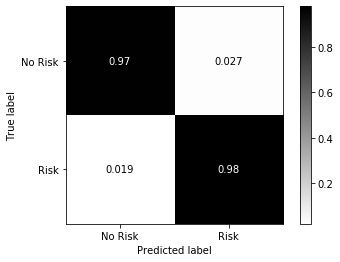

In [96]:
finalModel = models["DT-D9"] # Decision tree with depth 9.
finalDataSet = dataframes["imputedSelectedNoIpsi"] # Dataset with values imputed, unknown labels dropped, and ipsi removed.
TrainPred({"finalModel": finalModel}.items(), {"finalDataSet":finalDataSet}.items(), 5)

# Confusion matrix and classification report on test split.
data = finalDataSet.drop(columns="label")
labels = finalDataSet["label"]
xtr, xte, ytr, yte = skl.model_selection.train_test_split(data, labels, shuffle=True, random_state=69, test_size=0.3)

# Output confusion matrix plot.
skl.metrics.plot_confusion_matrix(finalModel, xte, yte, display_labels=["No Risk", "Risk"], normalize="true", cmap="gist_yarg")

# Output metrics dataframe.
TrainPred({"finalModel": finalModel}.items(), {"finalDataSet":finalDataSet}.items(), 5)

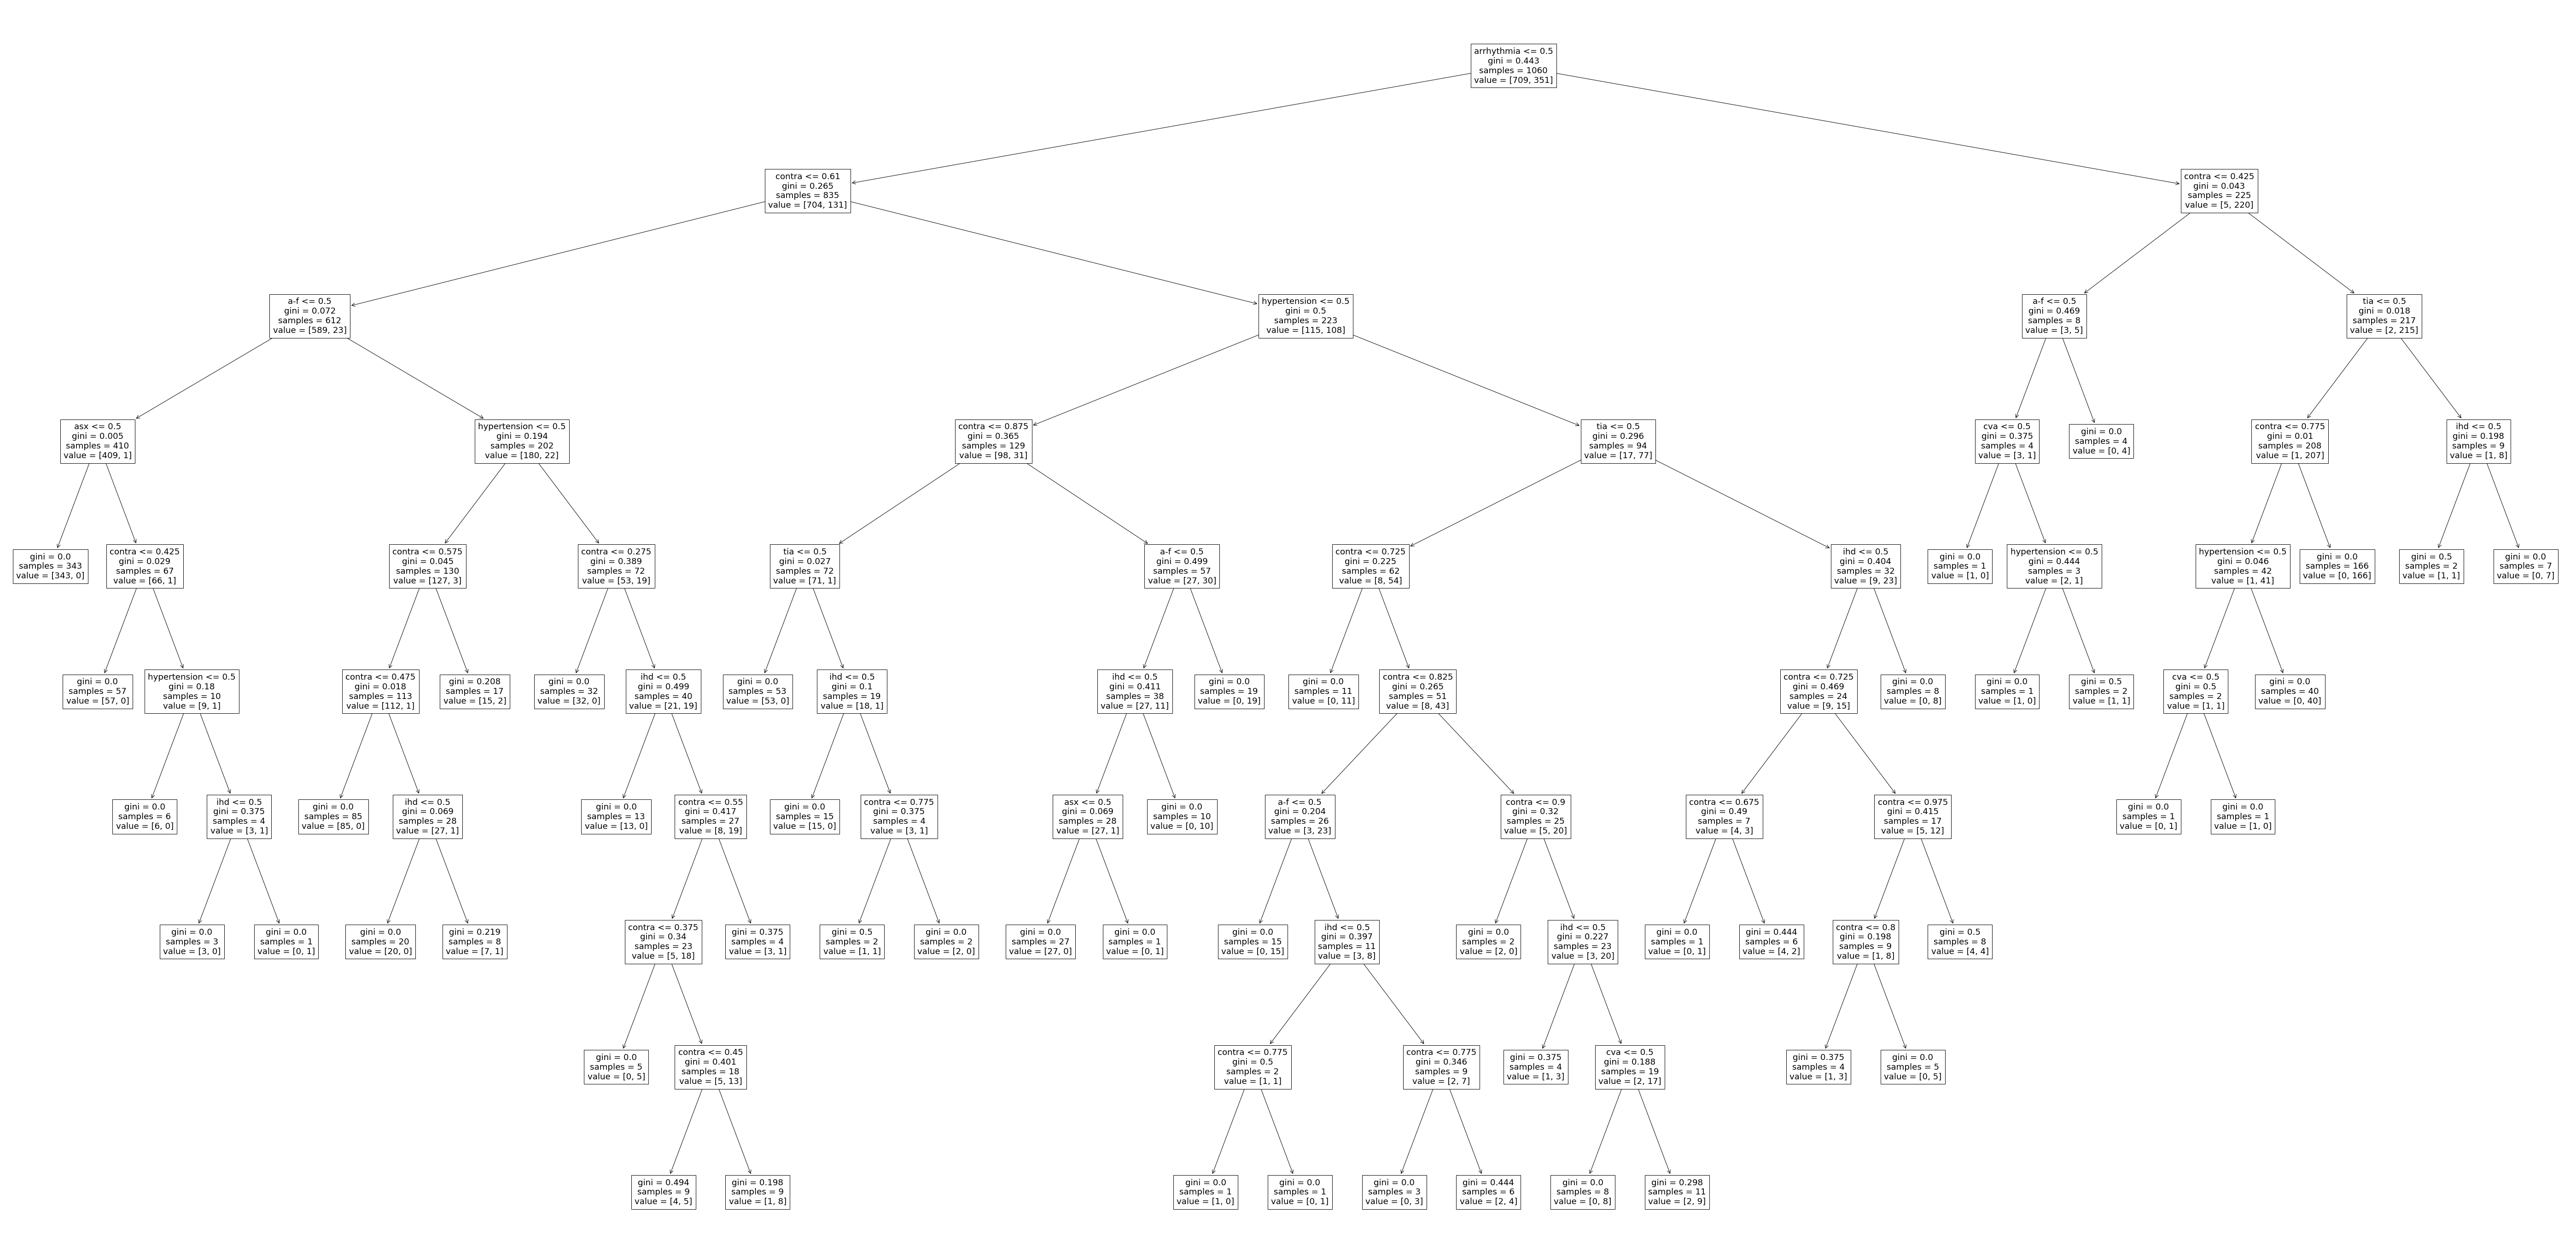

In [97]:
## Plot decision tree.
plt.figure(figsize=(100,50))
featureNames = finalDataSet.drop(columns=["label"]).columns.values
nodes = plot_tree(finalModel, feature_names=featureNames)

<hr>

# 5. Evaluation
This section is discussed in the acompanying report.

<hr>

# 6. Deployment
This section is discussed in the acompanying report.